# Bifurcation data analysis

In this notebook, let's create a workflow to process images from the **bifurcation** experiment. This will involve 3 steps:

- crop channel regions from raw images
- apply PIV on cropped images
- compute relevant numbers, e.g. flow rates in each channel, from PIV data 

## 1 Crop channel regions from raw images

In a typical bifurcation experiment, we have a 3-way micro-channel photoprinted on a resin. This micro-channel is cast on the active microtubule system at an oil-water interface. The chaotic turbulent-like motions of microtubules will be rectified by the micro-channels. Ratchet structures are used to set one of the channels as inlet. The flow then goes into either remaining channels, or into both at certain fractions. We study what is the "preferred" bifurcation of the flow. 

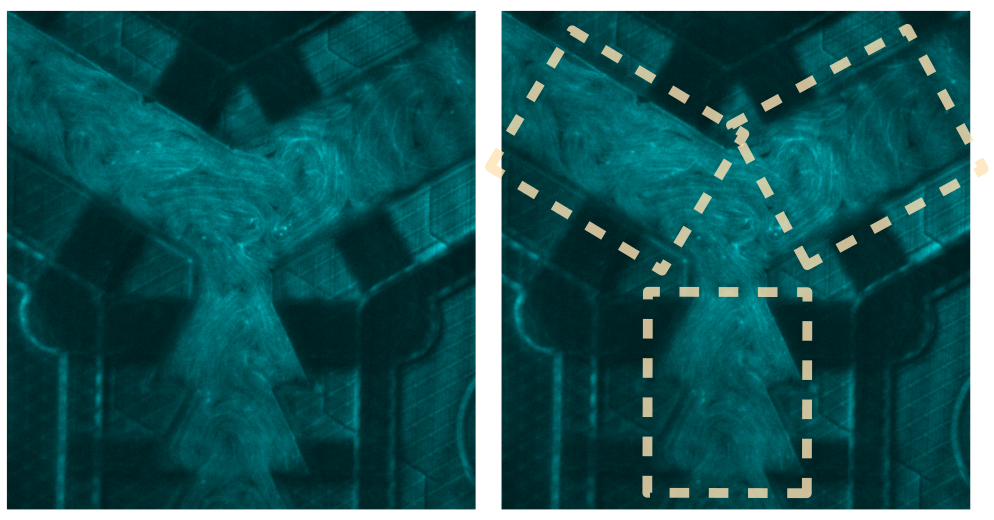

The above image (left) is an example microscopic view under a microscope. The bottom channel is modified with ratchet structures, and is therefore the inlet. The two branches on the top are the test channels. We want to measure the flow rate in the 3 channels separately. It's convenient to crop rectangular regions containing each branch, as shown in the right panel above. And then rotate the region to horizontal or vertical direction, so that the velocity along the channel direction is just the horizontal or vertical component of the measured velocity. 

In the following, let's write the code to crop the images. 

In [1]:
from skimage import io, draw
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import rotate
from matplotlib.patches import Rectangle
from myimagelib.myImageLib import readdata, bestcolor, show_progress, to8bit
import os
from myimagelib.pivLib import PIV, PIV_masked, read_piv, to_matrix, apply_mask, compact_PIV
from IPython.display import clear_output
from myimagelib.corrLib import divide_windows, corrS
from tifffile import imwrite
from nd2reader import ND2Reader
from scipy.io import loadmat

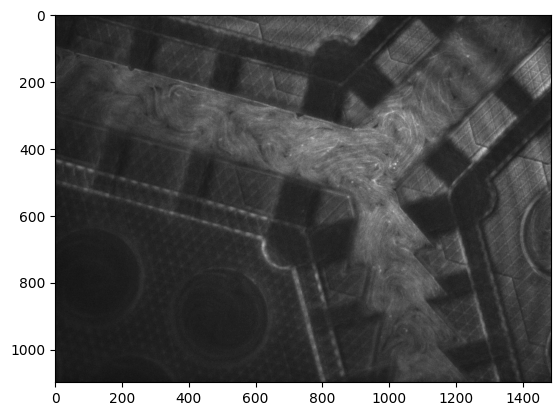

In [2]:
img = io.imread(r"test_files/crop-test.tif")
plt.imshow(img, cmap="gray")

The first step is to rotate the image, so that each channel have their +1 flow direction going up. For each channel, we need to rotate and crop once. Thus, for a 3-channel grid, we need the knowledge of 3 rotation angles and 3 crop region coordinates after respective rotations. We start by mannually provide these numbers. <font color="red">Later on, we will develop more intelligent algorithm that crops the image more automatically.</font>

### 1.1 Rotation

We want to rotate the raw image above to make, e.g. the ratchet channel, to go upward. We measure manually and find this channel is 14$^\circ$ to the left of the vertical axis. Therefore, we rotate the image -14$^\circ$ to get the desired orientation. 

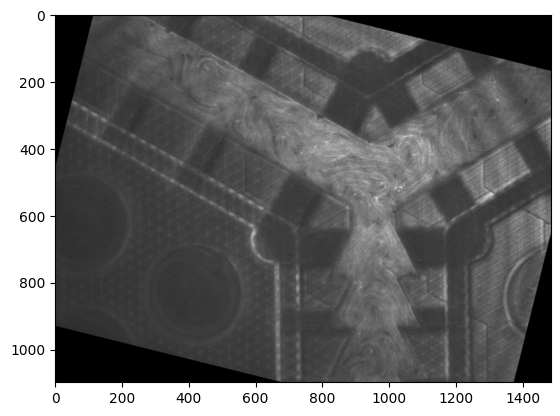

In [3]:
imgr = rotate(img, angle=-14)
plt.imshow(imgr, cmap="gray")

### 1.2 Crop

Next, we want to crop the ratchet channel from the rotated image. A rough measurement suggests that we can use a bounding box (774, 591, 345, 507).

**Note:** the bounding box is represented as (x0, y0, width, height), where x0, y0 are the coordinates of the upper left corner. Width and height are the side lengths of the box in x and y direction, respectively.

Run the block below, we see a red rectangle, indicating the bounding box on the left, and the cropped image on the right.

In [4]:
# show rotated image and crop region
x, y, w, h = (774, 591, 345, 507)
imgr = rotate(img, angle=angle)
crop = imgr[y:y+h, x:x+w] # When images are represented as matrix, the first axis is row (corresponding to y) and the second axis is column (corresponding to x)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(imgr, cmap="gray")
rect = Rectangle((x, y), w, h, fill=False, ec="red")
ax[0].add_patch(rect)
ax[1].imshow(crop, cmap="gray")

NameError: name 'angle' is not defined

### 1.3 Manual measurement in ImageJ



ImageJ provide convenient tools for measuring the angles and bounding boxes. From ImageJ, we manually get 3 sets of (rotation angle, crop rectangle), saved in the "crop-data.csv" file as a table (picture below). Here, important information is the angle in odd lines and (BX, BY, Width, Height) in even lines. For example, to get the first crop of the inlet ratchet channel, we first rotate the raw image (angle[1]-90) degrees. Then, crop the resulting image using the rectangle cornered at (X, Y) with width and height (Width, Height) in the second line (2). 

**Note:** when measuring angle, we draw a straight line in the direction of the channel. The direction of this drawing can make a difference to the angle measured. In this application, we always draw the line from the - direction to the + direction, so that in all cropped images, the + direction points upward.

Below is an example of crop data generated from ImageJ manual measurement. 

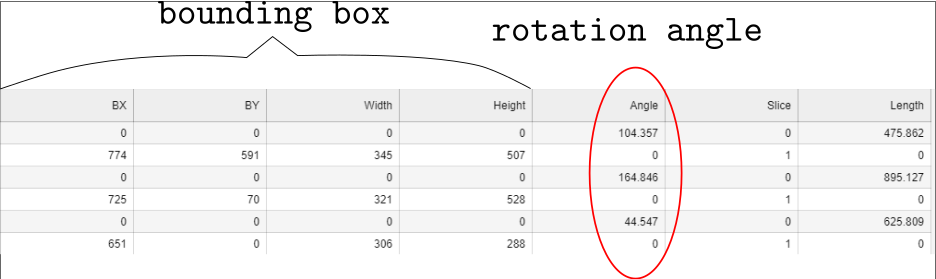

In [5]:
# load crop data from file
crop_data = pd.read_csv(r"test_files/crop-data.csv")
crop_data.head()

BX   BY  Width  Height    Angle  Slice   Length
0  1    0    0      0       0  104.357      0  475.862
1  2  774  591    345     507    0.000      1    0.000
2  3    0    0      0       0  164.846      0  895.127
3  4  725   70    321     528    0.000      1    0.000
4  5    0    0      0       0   44.547      0  625.809

In [6]:
# convert to angle, xy, wh
# use the first two rows of crop data as an example
angle = 90 - crop_data.at[0, "Angle"]
x, y, w, h = crop_data.at[1, "BX"], crop_data.at[1, "BY"], crop_data.at[1, "Width"], crop_data.at[1, "Height"]

### 1.4 Utility functions for cropping

#### 1.4.1 Preview crop

Now, we write a function to preview all the crops. In this specific channel design, we will generate 3 crops from a single image. However, the function here should be compatible with arbitrary numbers of crops. 

In [2]:
def preview_crop(img, crop_data):
    """Preview the channel crops.
    Args:
    img -- raw image
    crop_data -- rotation angle and rectangle descriptor, generate manually from ImageJ
    """
    ncrops = len(crop_data) // 2
    img_in_row = 3
    nrows = ncrops // 3 + 1
    fig = plt.figure(figsize=(6, 2*nrows))
    
    for i in range(0, ncrops):
        angle = 90 - crop_data.at[2*i, "Angle"]
        x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
        imgr = rotate(img, angle=angle)
        crop = imgr[y:y+h, x:x+w]
        ax = fig.add_subplot(nrows, img_in_row, i+1)
        ax.imshow(crop, cmap="gray")

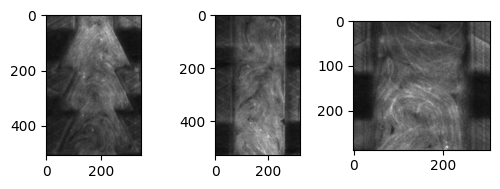

In [8]:
img = io.imread(r"test_files/crop-test.tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
preview_crop(img, crop_data)

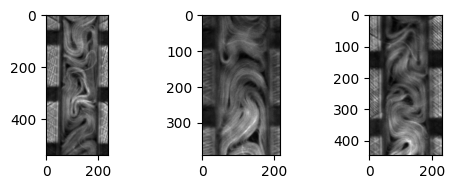

In [11]:
folder = r"A:\SYMMETRIC\14 dec 2022\nd2"
with ND2Reader(os.path.join(folder, "00.nd2")) as images:
    img = images[0]
crop_data = pd.read_csv(os.path.join(folder, "crop_data.csv"))
preview_crop(img, crop_data)

#### 1.4.2 Crop an image sequence

Next, we write a function to crop an image sequence, using the same crop-data.

In [9]:
def crop_sequence(sequence, crop_data, save_folder):
    """Crop an image sequence and save the resulting crops into respective folder.
    Crop folders will be named 0, 1, 2 ...
    Args:
    sequence -- return value of readdata
    crop_data -- manually generated ImageJ rotation and crop data
    save_folder -- master folder to save cropped images
    
    .. rubric:: Edit
    
    :Nov 30, 2022: Use :py:func:`tifffile.imwrite` to save .tif images.
    """
    ncrops = len(crop_data) // 2
    crop_folder = {}
    for i in range(ncrops):
        crop_folder[i] = os.path.join(save_folder, "crop-{:d}".format(i))
        if os.path.exists(crop_folder[i]) == False:
            os.makedirs(crop_folder[i])
    for num, item in sequence.iterrows():
        img = io.imread(item.Dir)
        name = item.Name
        for i in range(0, ncrops):
            angle = 90 - crop_data.at[2*i, "Angle"]
            x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
            imgr = rotate(img, angle=angle)
            crop = imgr[y:y+h, x:x+w]
            imwrite(os.path.join(crop_folder[i], "{}.tif".format(name)), crop)

In [10]:
seq = readdata("test_files", "tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
save_folder = r"test_files/cropped_images"
crop_sequence(seq, crop_data, save_folder)

### 1.5 Batch crop

Quick batch work, to test if the code works in a more realistic context. If the processing time is long, turn to commandline.

<font color="red"> NOT for real batch processing. This is just a code example! </font>

In [67]:
# external disk test
folder = r"E:\AN\10172022"
for n in range(4, 19):
    seq = readdata(os.path.join(folder, "{:02d}".format(n), "remove-background"), "tif")
    crop_data = pd.read_csv(r"test_files/crop-data.csv")
    save_folder = os.path.join(folder, "channel_crops_rb", "{:02d}".format(n))
    if os.path.exists(save_folder) == False:
        crop_sequence(seq, crop_data, save_folder)

## 2 Flow rate analysis

### 2.1 PIV

#### 2.1.1 Normal PIV on cropped images

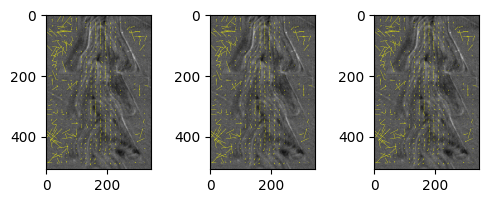

In [11]:
folder = "test_files/PIV"
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))
for i in range(3):
    I0 = io.imread(os.path.join(folder, "0000.tif"))
    I1 = io.imread(os.path.join(folder, "0001.tif"))
    x, y, u, v = PIV(I0, I1, 32, 16, 1)
    ax[i].imshow(I0, cmap="gray")
    ax[i].quiver(x, y, u, v, color="yellow")

#### 2.2.2 Masked PIV

I wrote a function `PIV_masked` to incorporate masking procedure to a normal PIV. Here, let's test it.

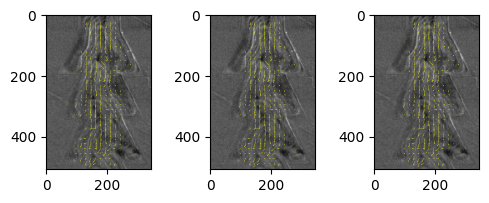

In [12]:
folder = "test_files/PIV"
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))
for i in range(3):
    I0 = io.imread(os.path.join(folder, "0000.tif"))
    I1 = io.imread(os.path.join(folder, "0001.tif"))
    mask = io.imread("test_files/mask/mask.tif")
    x, y, u, v = PIV_masked(I0, I1, 32, 16, 1, mask)
    ax[i].imshow(I0, cmap="gray")
    ax[i].quiver(x, y, u, v, color="yellow")

#### 2.2.3 Apply mask strategy

Recently, when reading OpenPIV documents, I realize that there is a better strategy to store masked PIV data: on top of x, y, u, v columns, add a mask column, which labels if PIV data at certain points are valid or not. Although it will take slightly more space to store an additional column, compared to my old way to just replace invalid velocities with `np.nan`, this strategy allows me to recover the original PIV results without running the cross-correlation algorithm again. This is especially useful when we want to test different masks, e.g. different treatments to the boundaries.

This strategy is implemented in `apply_mask()`.

In [13]:
pivData = pd.read_csv("test_files/PIV/0000-0001.csv")
mask = io.imread("test_files/mask/mask.tif")
pivMasked = apply_mask(pivData, mask)

In [14]:
pivMasked.head()

x     y         u         v   mask
0  19.5  20.5  0.000000  0.000000  False
1  35.5  20.5  0.000000  0.020879  False
2  51.5  20.5  0.000000  0.020879  False
3  67.5  20.5 -0.003421  0.000000  False
4  83.5  20.5 -0.050930  0.000000  False

The invalid velocity data will be labeled `False` in mask column. When creating `np.nan` stuffed data, do as the block below:

In [16]:
pivnan = pivMasked.copy()
pivnan.loc[~pivMasked["mask"], ["u", "v"]] = np.nan
pivnan.head()

x     y   u   v   mask
0  19.5  20.5 NaN NaN  False
1  35.5  20.5 NaN NaN  False
2  51.5  20.5 NaN NaN  False
3  67.5  20.5 NaN NaN  False
4  83.5  20.5 NaN NaN  False

#### 2.2.4 Check PIV results

Don't use too long range. Usually, 10 frames should be fine.

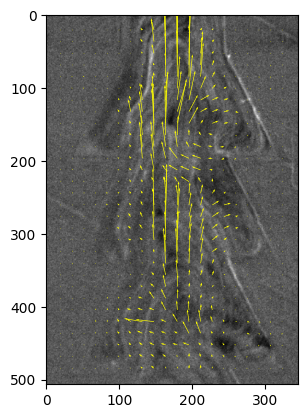

In [17]:
img_folder = "test_files/PIV"
piv_folder = "test_files/PIV"
limg = readdata(img_folder, "tif")
lpiv = readdata(piv_folder, "csv")
for i in range(1):
    img = io.imread(limg.at[i*2, "Dir"])
    x, y, u, v = read_piv(lpiv.at[i, "Dir"])
    plt.imshow(img, cmap="gray")
    plt.quiver(x, y, u, v, color="yellow")
    plt.pause(0.1)
    clear_output(wait=True)

### 2.2 PIV to flow rate

We assume the active nematics system is imcompressible and use volumetric flow rate $Q$ as the flow rate that should be conserved at each point in the channel. 

In each of the cropped channel region, we know from the videos that the primary flow direction is along the channel directions, either being positive or negative. Therefore, we only extract flow in these directions, i.e. the $y$-axis in the cropped images. To get $Q_y$, we integrate velocity $v_y$ along $x$ at an arbitrary $y$ position:
$$
Q_y = \int_{x_1}^{x_2} v_y(x, y)dx
$$
To minimize the noise from the arbitrary choice of $y$ position, we can take an average of $Q_y$ over $y$:
$$
\left< Q_y \right> = \frac{1}{L}\int_0^{L} Q_y dy = \frac{1}{L}\int_0^{L} \int_{x_1}^{x_2} v_y(x, y)dx dy
$$
For a rectangular channel, $x_1$ and $x_2$ are constant for all $y$, so the mean flow rate can be simplified to 
$$
\left< Q_y \right> = W \left< v_y \right>_{x, y}
$$
For ratchet channels (or other non-rectangular channels), where channel width $W$ is not a constant along $y$, we need to compute
$$
\left< Q_y \right> = \frac{1}{L}\int_0^{L} W(y) \left<v_y\right>_x dy
$$

In [71]:
def compute_flowrate(v, winsize):
    """Compute flow rate in channels based on masked PIV data.
    Args:
    v -- masked PIV velocity in channel direction. (px/s) ([x, y(, t)] array)
    winsize -- PIV window size in pixel. (px) 
    Returns:
    Q -- flow rate (px^2/s)
    IMPORTANT:
    Overlap is always half of winsize."""
    mask = ~np.isnan(v)
    W = np.count_nonzero(mask, axis=1) # channel width (number of windows)
    w = W * winsize / 2 # channel width (px)
    v_meanx = np.nanmean(v, axis=1)
    Q = np.nanmean(w * v_meanx, axis=0)
    return Q

In [72]:
piv_folder = r"E:\AN\10172022\channel_piv_rb"
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
if os.path.exists(flowrate_folder) == False:
    os.makedirs(flowrate_folder)
n = 4
winsize = 32
sfL = ["crop-0", "crop-1", "crop-2"]
for n in range(4, 19):
    df = pd.DataFrame()
    for sf in sfL:
        l = readdata(os.path.join(piv_folder, "{:02d}".format(n), sf), "csv")
        tmp = []
        for num, i in l.iterrows():
            x, y, u, v = read_piv(i.Dir)
            tmp.append(v)
        vstack = np.stack(tmp, axis=2)
        Q = compute_flowrate(vstack, winsize)
        df[sf] = Q
    # set time column
    df["t"] = df.index * 2 # 1 fps, PIV 2 frame
    df.to_csv(os.path.join(flowrate_folder, "{:02}.csv".format(n)), index=False)

C:\Users\liuzy\AppData\Local\Temp\ipykernel_19564\396871552.py:13: RuntimeWarning: Mean of empty slice
  v_meanx = np.nanmean(v, axis=1)


### 2.3 Plot flow rate time series

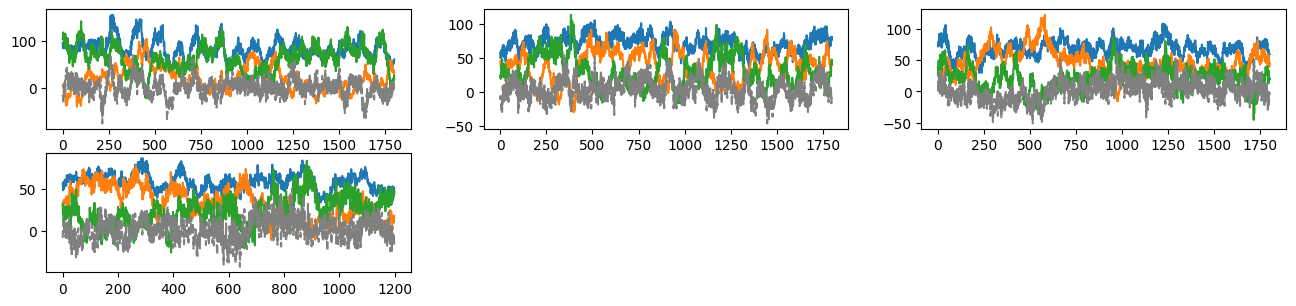

In [256]:
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
n = 13
fig = plt.figure(figsize=(16, 9), dpi=100)
for num, n in enumerate(range(1,5)):
    data = pd.read_csv(os.path.join(flowrate_folder, "{:02d}.csv".format(n)))
    ax = fig.add_subplot(5, 3, num+1)
    ax.plot(data.t, data["crop-0_rb"], label="$A$")
    ax.plot(data.t, data["crop-1_rb"], label="$B$")
    ax.plot(data.t, data["crop-2_rb"], label="$C$")
    # ax.set_xlabel("$t$ (s)")
    # ax.set_ylabel("flow rate (px$^2$/s)")
    ax.plot(data.t, data["crop-0_rb"] - data["crop-1_rb"] - data["crop-2_rb"], color="gray", ls="--", label="$A-B-C$")
    
    # ax.legend(frameon=False)

### 2.4 Normalize flow rate

In [74]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
flow_data = pd.read_csv(os.path.join(flowrate_folder_rb, "14.csv"))
flow_data.head()

crop-0      crop-1      crop-2  t
0  370.817845  653.337855 -195.456327  0
1  343.999827  667.574907 -180.495546  2
2  317.374682  703.399163 -154.375359  4
3  270.075610  586.576472 -241.117395  6
4  291.124701  621.510550 -235.715612  8

In [75]:
norm = flow_data["crop-0"].mean()
norm_flow_data = flow_data.copy()
mean0 = norm_flow_data["crop-0"].mean()
norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0

Text(0, 0.5, 'flow rate (px$^2$/s)')

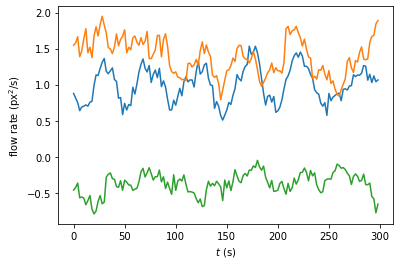

In [78]:
fig, ax = plt.subplots()
ax.plot(norm_flow_data.t, norm_flow_data["crop-0"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-1"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-2"])
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")

## 3 Test preprocess - subtract background (in particular the dark concentric rings)

We notice that the images from the Gulliver confocal always have outstanding concentric dark rings, likely caused by the confocal spin unit (CSU). In the previous sections, we have analyzed the images without correcting these rings. Here, we compare the results from with/without correction, to see if a correction is necessary. If necessary, we will implement a python version of batch background subtration. 

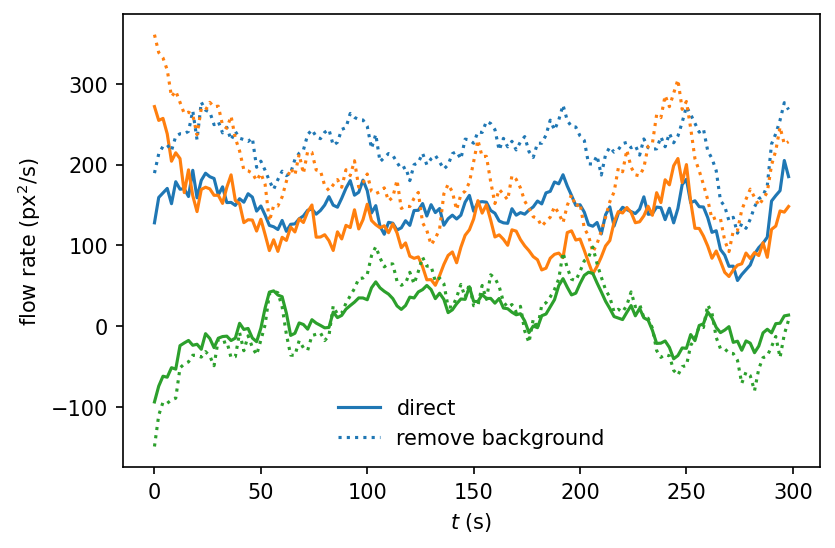

In [30]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate"
flowrate_folder_rb = r"E:\AN\10172022\channel_flowrate_rb"
n = 5
# fig = plt.figure(figsize=(16, 9), dpi=100)
fig, ax = plt.subplots(dpi=150)
data = pd.read_csv(os.path.join(flowrate_folder, "{:02d}.csv".format(n)))
data_rb = pd.read_csv(os.path.join(flowrate_folder_rb, "{:02d}.csv".format(n)))
# ax = fig.add_subplot(5, 3, num+1)
ax.plot(data.t, data["crop-0"], label="direct", color=bestcolor(0))
ax.plot(data.t, data["crop-1"], color=bestcolor(1))
ax.plot(data.t, data["crop-2"], color=bestcolor(2))
ax.plot(data.t, data_rb["crop-0"], label="remove background", color=bestcolor(0), ls=":")
ax.plot(data.t, data_rb["crop-1"], color=bestcolor(1), ls=":")
ax.plot(data.t, data_rb["crop-2"], color=bestcolor(2), ls=":")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")
# ax.plot(data.t, data["crop-0"] - data["crop-1"] - data["crop-2"], color="gray", ls="--", label="$A-B-C$")

ax.legend(frameon=False)

The above comparison suggests that there is noticealbe difference between PIV on images with/without background subtraction. On images where background is subtracted, the measured velocity is generally larger than original images. This is expected because the dark rings in the images are stationary patterns, which make the detected motion slower. In the future, all the PIV should be done on images where background is subtracted. Here, we implement a code to batch process raw images. 

### 3.1 Median z-projection

In [32]:
raw_folder = r"E:\AN\10122022\00\raw"
rb_folder = r"E:\AN\10122022\00\remove-background"
if os.path.exists(rb_folder) == False:
    os.makedirs(rb_folder)
l = readdata(raw_folder, "tif")
imgs = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    imgs.append(img)
stack = np.stack(imgs, axis=0) # TXY image stack

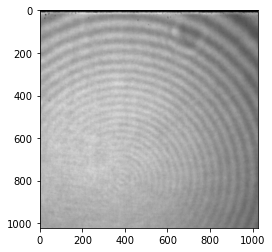

In [33]:
# median projection
med = np.median(stack, axis=0)
plt.imshow(med, cmap="gray")

### 3.2 Divide raw images by the median projection

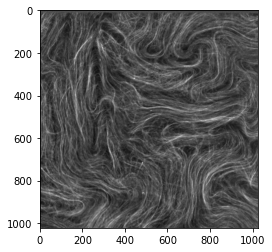

In [34]:
img = stack[0]
plt.imshow(img/med, cmap="gray")

In [52]:
subtract_stack = np.divide(stack, med)
img = subtract_stack[0]
plt.imshow(img, cmap="gray")

MemoryError: Unable to allocate 43.7 GiB for an array with shape (3601, 1098, 1484) and data type float64

Unable to do `np.divide` with the whole stack, because memory is not enough. But it's possible to do it frame-wise.

In [35]:
imgr0 = stack[0] / med
low, high = imgr0.min(), imgr0.max()
for num, img in enumerate(stack):
    imgr = img / med
    img8 = ((imgr - low) / (high - low) * 255).astype(np.uint8)
    io.imsave(os.path.join(rb_folder, "{:05d}.tif".format(num)), img8)

### 3.3 Remove tiffstack background

In [3]:
img_folder = r"A:\SYMMETRIC\14 dec 2022\nd2\crop_channel"
stack = io.imread(os.path.join(img_folder, "00_A.tif"))
med = np.median(stack, axis=0)

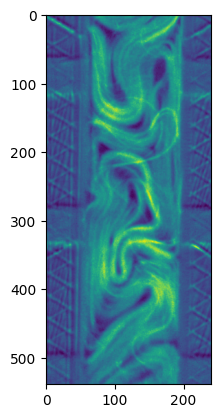

In [7]:
plt.imshow((stack / med)[0])

## 4 Flow configuration probability

We plot the histogram of flow configuration on a $\phi_B$-$\phi_C$ axis. Note that for original flow rate data (with physical units), we can plot histogram for each video, or even different videos of a day. But due to the fact that microtubule activity varies from day to day, mixing flow rate data from multiple days creates chaos. In this case, we can normalize the flow rate data first and then combine in the same histogram plot. 

In [217]:
flowrate_folder = r"C:\Users\liuzy\Documents\10172022\04"
flow_data = pd.read_csv(os.path.join(flowrate_folder, "flowrate.csv"))
flow_data.head()

crop-0      crop-1      crop-2  t
0  379.661608  411.381052  -94.305390  0
1  247.928972  341.664000  -95.563626  1
2  206.866166  420.423743 -184.947396  2
3  205.057971  431.254114 -183.407506  3
4  224.290620  411.595539 -176.983738  4

### 4.1 Normalize the flow rate data

In [218]:
norm = flow_data["crop-0"].mean()
norm_flow_data = flow_data.copy()
mean0 = norm_flow_data["crop-0"].mean()
norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0

Text(0, 0.5, 'flow rate (px$^2$/s)')

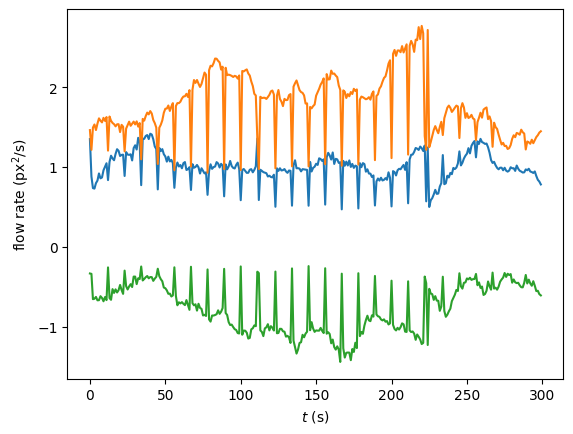

In [219]:
fig, ax = plt.subplots()
ax.plot(norm_flow_data.t, norm_flow_data["crop-0"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-1"])
ax.plot(norm_flow_data.t, norm_flow_data["crop-2"])
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")

### 4.2 Histogram of normalized flow rate

In [215]:
H, xedges, yedges = np.histogram2d(norm_flow_data["crop-1"], norm_flow_data["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])

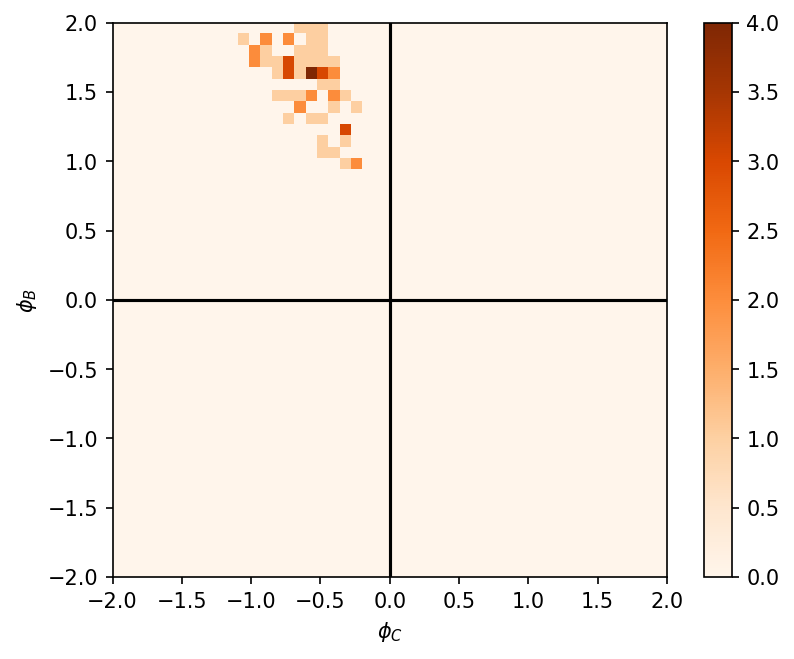

In [216]:
plt.figure(dpi=150)
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.plot([-2, 2], [0, 0], color="black")
plt.plot([0, 0], [-2, 2], color="black")
plt.xlabel("$\phi_C$")
plt.ylabel("$\phi_B$")
plt.colorbar()

Text(0, 0.5, '$\\phi_B$')

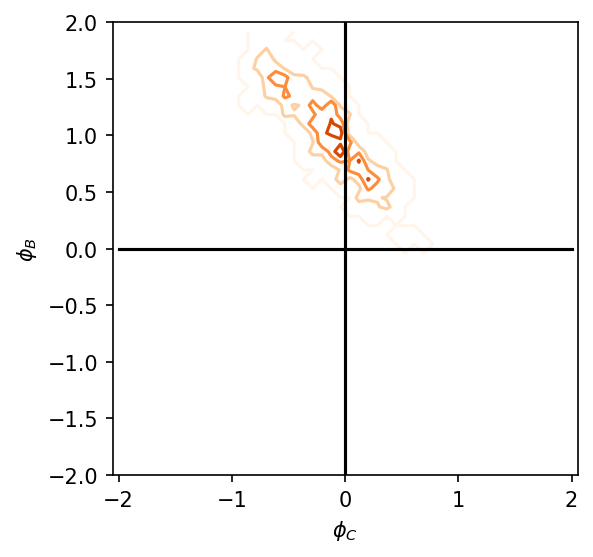

In [155]:
# Contour plot
plt.figure(figsize=(4, 4), dpi=150)
levels = np.linspace(np.min(H), np.max(H), 5)

plt.axis("equal")
plt.contour(xedges[:-1], yedges[:-1], H, levels=levels, cmap="Oranges")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot([-2, 2], [0, 0], color="black")
plt.plot([0, 0], [-2, 2], color="black")
# plt.colorbar()
plt.xlabel("$\phi_C$")
plt.ylabel("$\phi_B$")

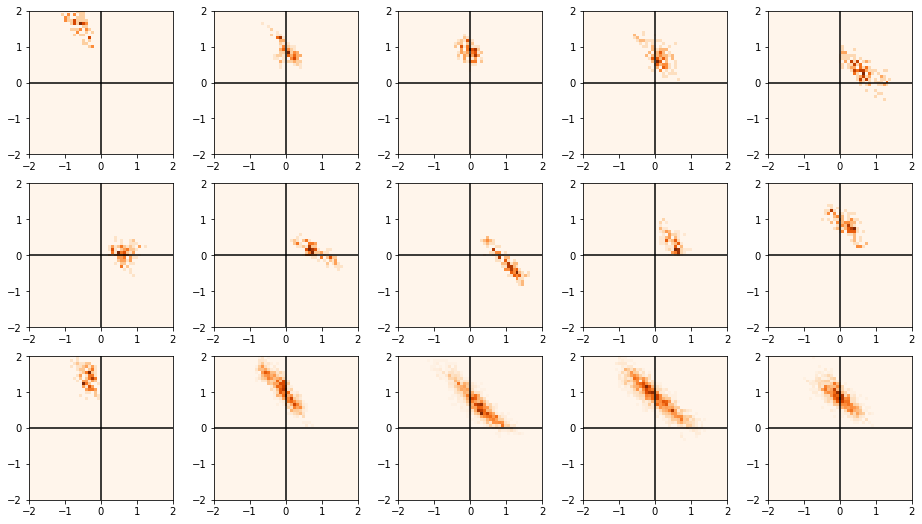

In [160]:
fig = plt.figure(figsize=(16, 9))
num = 1
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"

for n in range(4, 19):
    ax = fig.add_subplot(3, 5, num)
    flow_data = pd.read_csv(os.path.join(flowrate_folder_rb, "{:02d}.csv".format(n)))
    norm = flow_data["crop-0"].mean()
    norm_flow_data = flow_data.copy()
    mean0 = norm_flow_data["crop-0"].mean()
    norm_flow_data[["crop-0", "crop-1", "crop-2"]] /= mean0
    H, xedges, yedges = np.histogram2d(norm_flow_data["crop-1"], norm_flow_data["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black")
    ax.plot([0, 0], [-2, 2], color="black")
    num += 1

In [14]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate_rb"
l = readdata(flowrate_folder, "csv")
flow_list = []
for num, i in l.iterrows():
    flow_data = pd.read_csv(i.Dir)
    flow_list.append(flow_data)
data = pd.concat(flow_list)

In [18]:
data

crop-0      crop-1      crop-2     t
0     284.903891  340.803741  -68.501938     0
1     232.526922  344.393668  -87.746131     2
2     230.371388  340.838579  -84.528879     4
3     213.858281  313.205306  -64.247718     6
4     214.690617  283.612907  -81.880799     8
...          ...         ...         ...   ...
1095  626.656957  524.968666  -64.303204  2190
1096  632.669688  364.434556  -31.345588  2192
1097  596.160480  437.964529   52.103395  2194
1098  495.850733  497.187587  121.681686  2196
1099  641.734328  426.872548   64.186242  2198

[7381 rows x 4 columns]

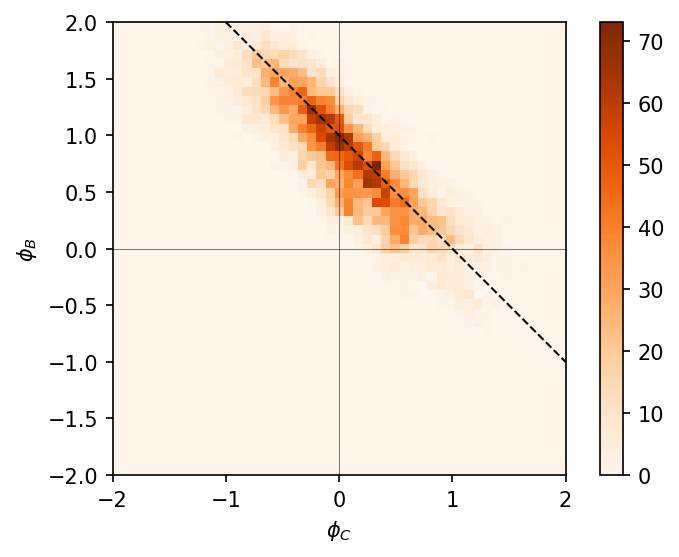

In [17]:
norm_data = data.copy()
norm_data[["crop-0", "crop-1", "crop-2"]] /= norm_data["crop-0"].mean()
H, xedges, yedges = np.histogram2d(norm_data["crop-1"], norm_data["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
plt.figure(dpi=150)
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
plt.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
plt.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
plt.xlabel("$\phi_C$")
plt.ylabel("$\phi_B$")
plt.colorbar()

### 4.3 Histogram along the "mass conservation" line (black dashed line)

In [22]:
line_pixels = H[draw.line(48, 12, 12, 48)]

Text(0, 0.5, 'histogram')

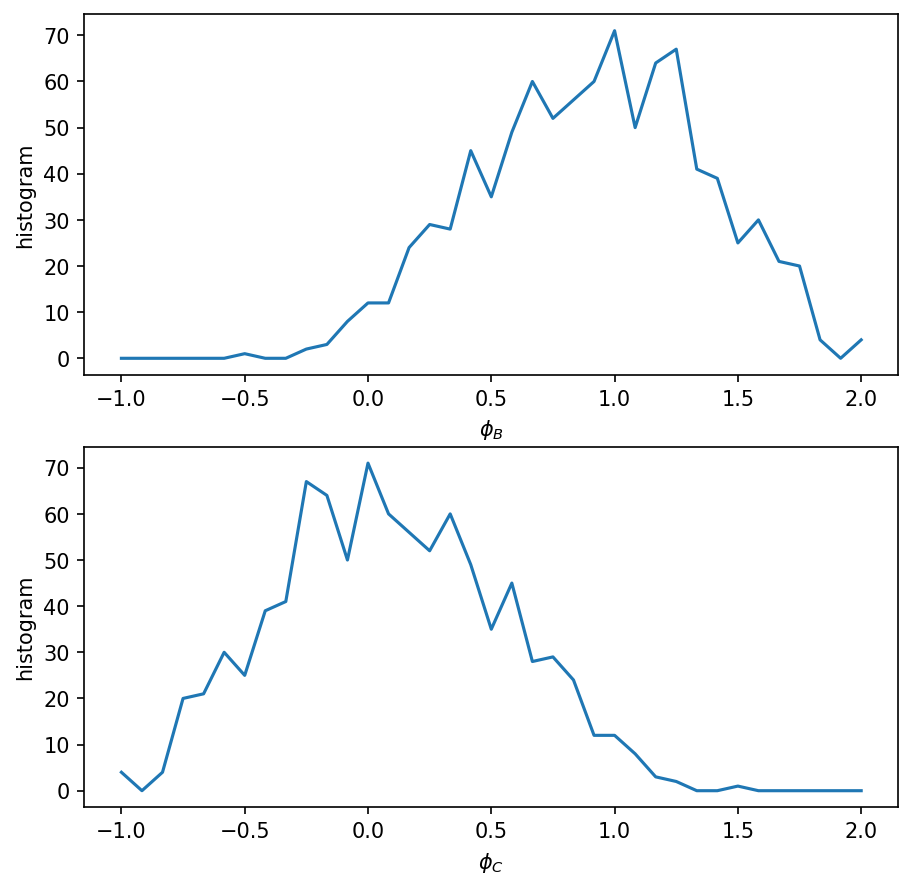

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), dpi=150)
ax[0].plot(np.linspace(2, -1, len(line_pixels)), line_pixels)
ax[0].set_xlabel("$\phi_B$")
ax[0].set_ylabel("histogram")
ax[1].plot(np.linspace(-1, 2, len(line_pixels)), line_pixels)
ax[1].set_xlabel("$\phi_C$")
ax[1].set_ylabel("histogram")

### 4.4 Data visualization by date

#### 4.4.1 10312022 Data

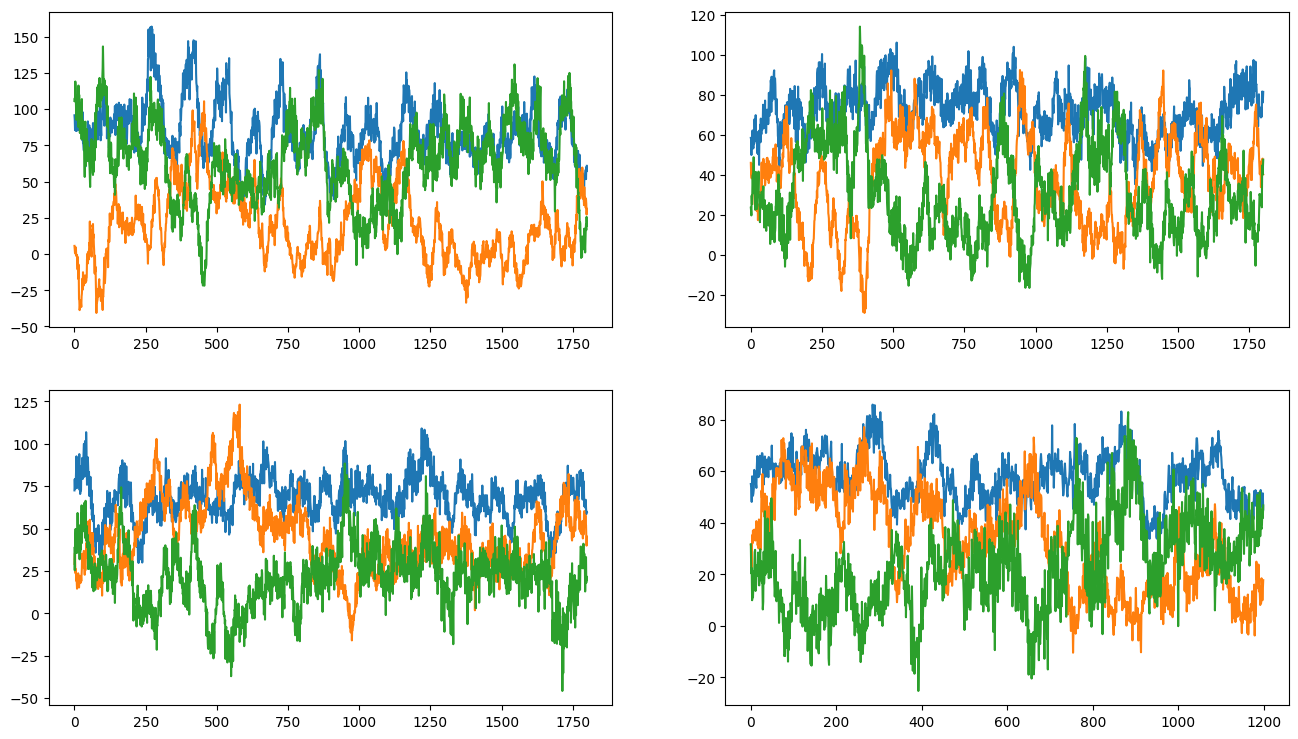

In [257]:
# flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    ax.plot(fr["t"], fr["crop-0_rb"])
    ax.plot(fr["t"], fr["crop-1_rb"])
    ax.plot(fr["t"], fr["crop-2_rb"])

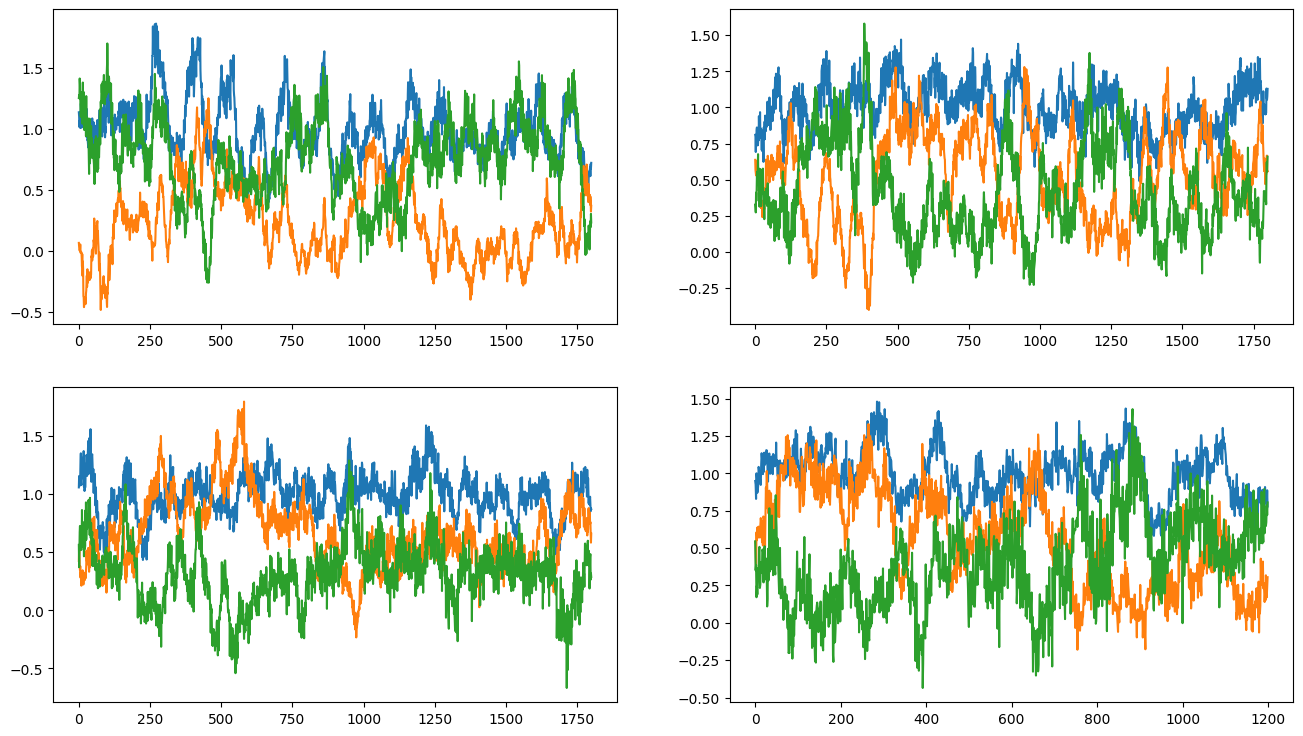

In [259]:
# normalized flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm = fr["crop-0_rb"].mean()
    ax.plot(fr["t"], fr["crop-0_rb"]/norm)
    ax.plot(fr["t"], fr["crop-1_rb"]/norm)
    ax.plot(fr["t"], fr["crop-2_rb"]/norm)

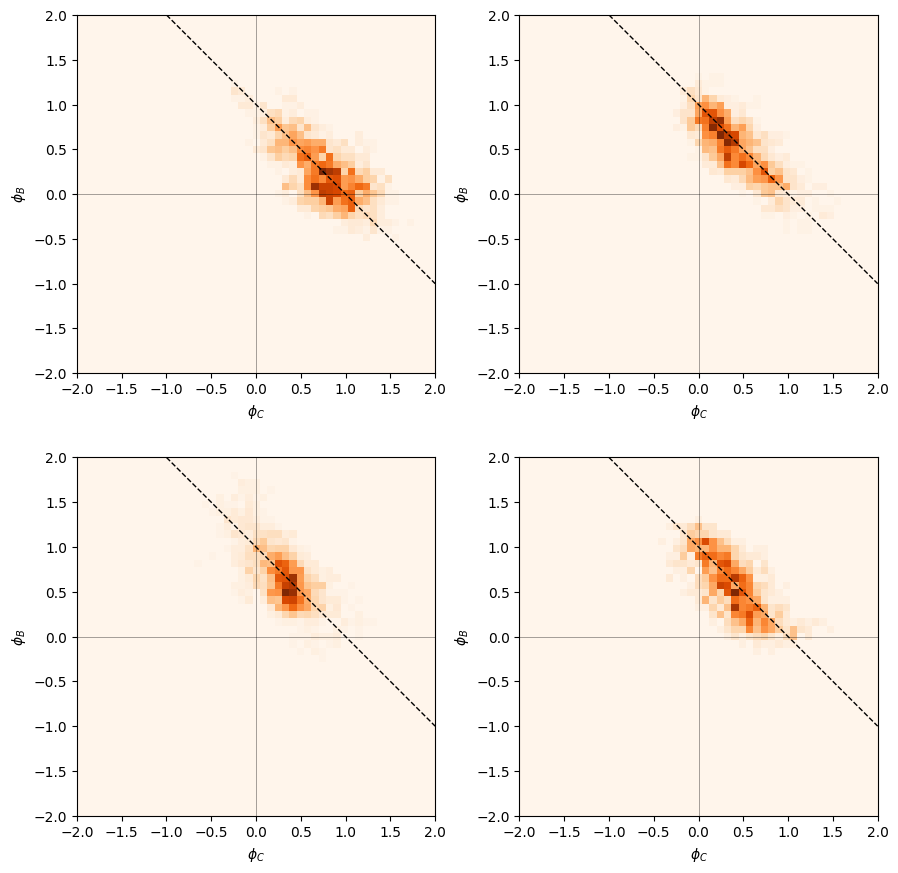

In [265]:
# Histogram of normalized flow rate (each)
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm_data["crop-0_rb"].mean()
    H, xedges, yedges = np.histogram2d(norm_data["crop-1_rb"], norm_data["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
    ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
    ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
    ax.set_xlabel("$\phi_C$")
    ax.set_ylabel("$\phi_B$")
plt.tight_layout()

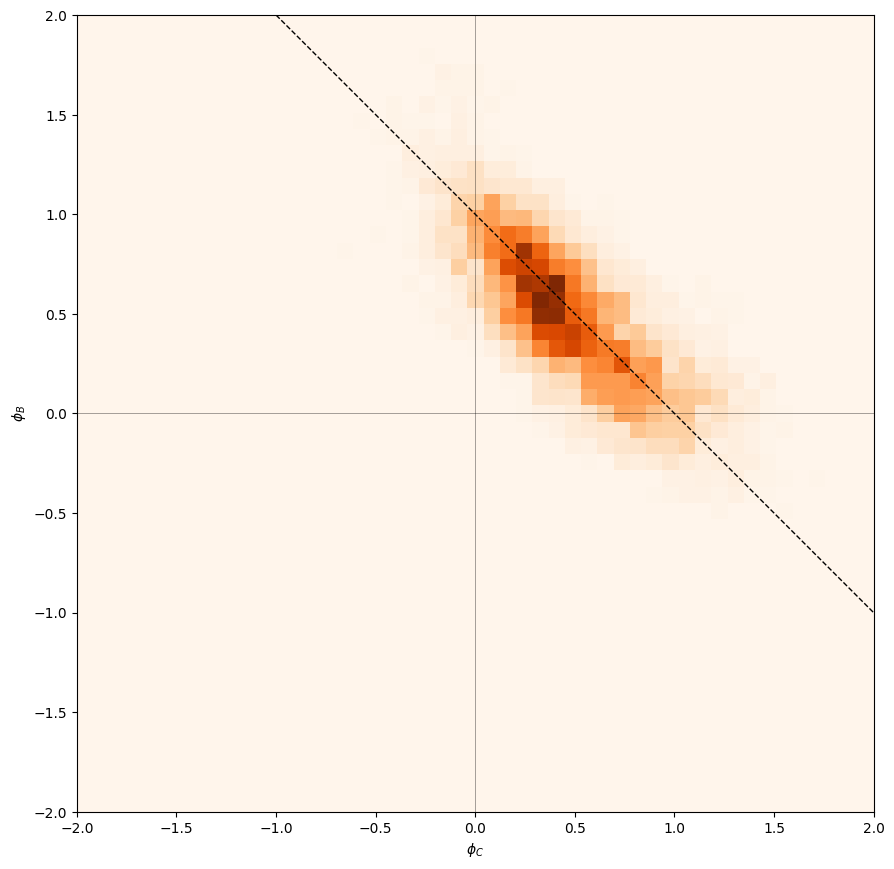

In [266]:
# Combine the histogram
flowrate_folder = r"C:\Users\liuzy\Documents\10312022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
data = []
for num, i in l.iterrows():    
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm_data["crop-0_rb"].mean()
    data.append(norm_data)
combine = pd.concat(data, axis=0)
H, xedges, yedges = np.histogram2d(combine["crop-1_rb"], combine["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
ax = fig.add_subplot(1, 1, 1)
ax.imshow(H, interpolation='nearest', origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
ax.set_xlabel("$\phi_C$")
ax.set_ylabel("$\phi_B$")
plt.tight_layout()

#### 4.4.2 11042022 Data

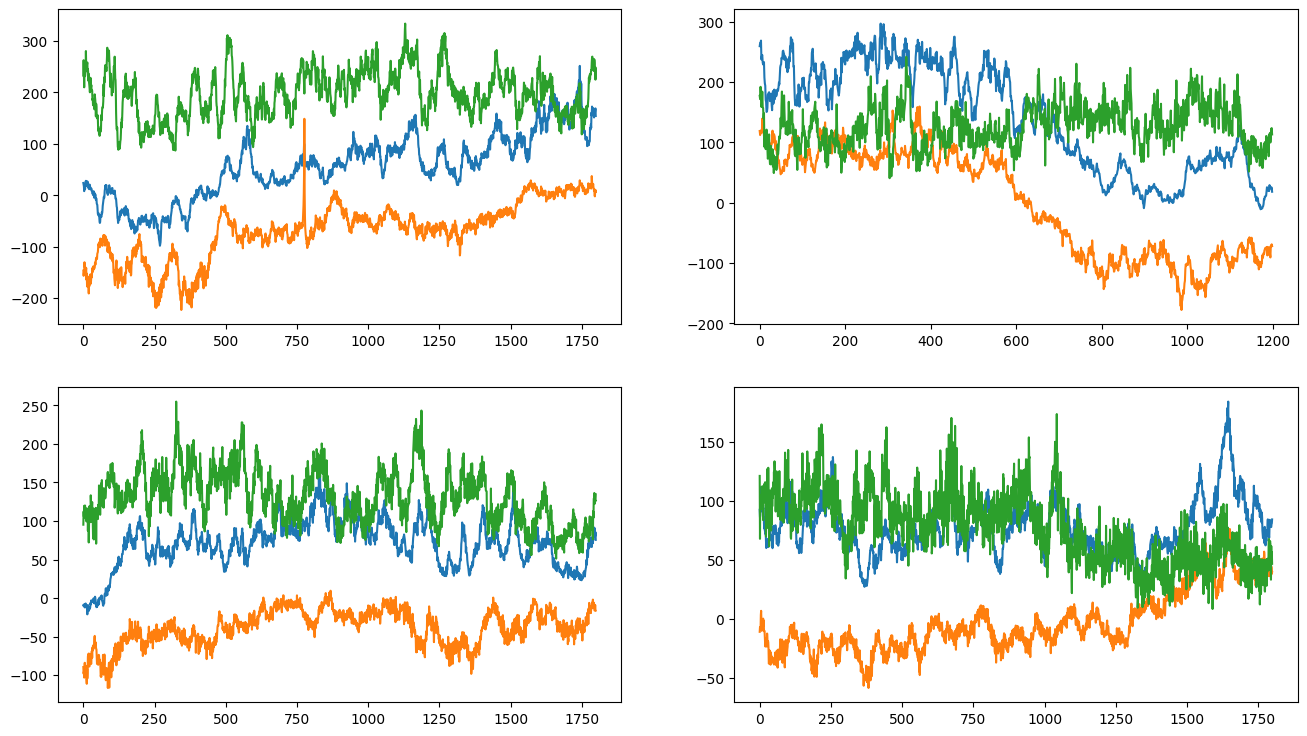

In [273]:
# flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\11042022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    ax.plot(fr["t"], fr["crop-0_rb"])
    ax.plot(fr["t"], fr["crop-1_rb"])
    ax.plot(fr["t"], fr["crop-2_rb"])

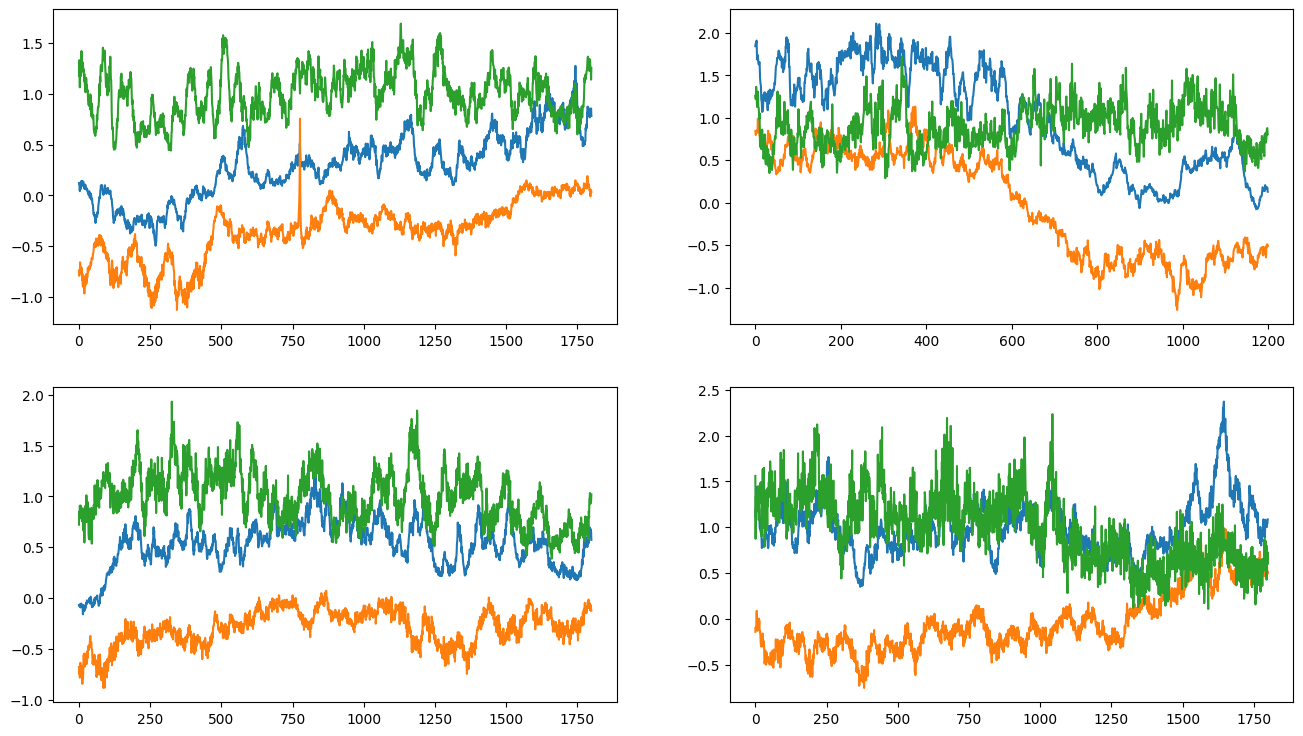

In [280]:
# normalized flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\11042022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    ax.plot(fr["t"], fr["crop-0_rb"]/norm)
    ax.plot(fr["t"], fr["crop-1_rb"]/norm)
    ax.plot(fr["t"], fr["crop-2_rb"]/norm)

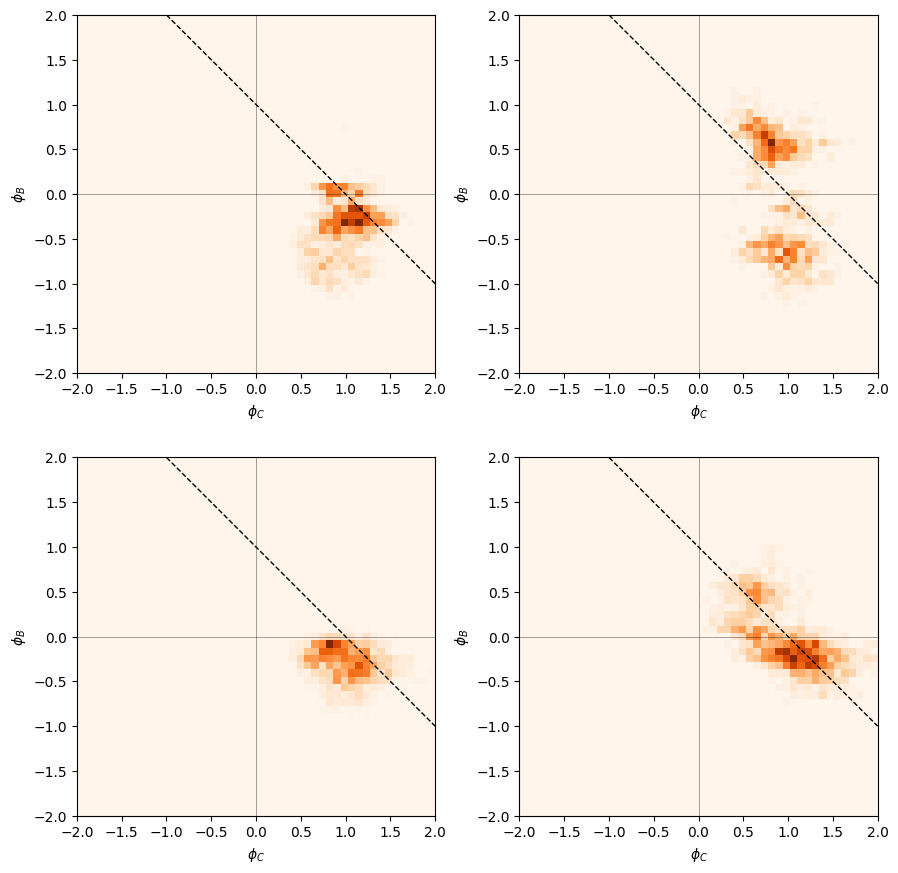

In [281]:
# Histogram of normalized flow rate (each)
flowrate_folder = r"C:\Users\liuzy\Documents\11042022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm
    H, xedges, yedges = np.histogram2d(norm_data["crop-1_rb"], norm_data["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
    ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
    ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
    ax.set_xlabel("$\phi_C$")
    ax.set_ylabel("$\phi_B$")
plt.tight_layout()

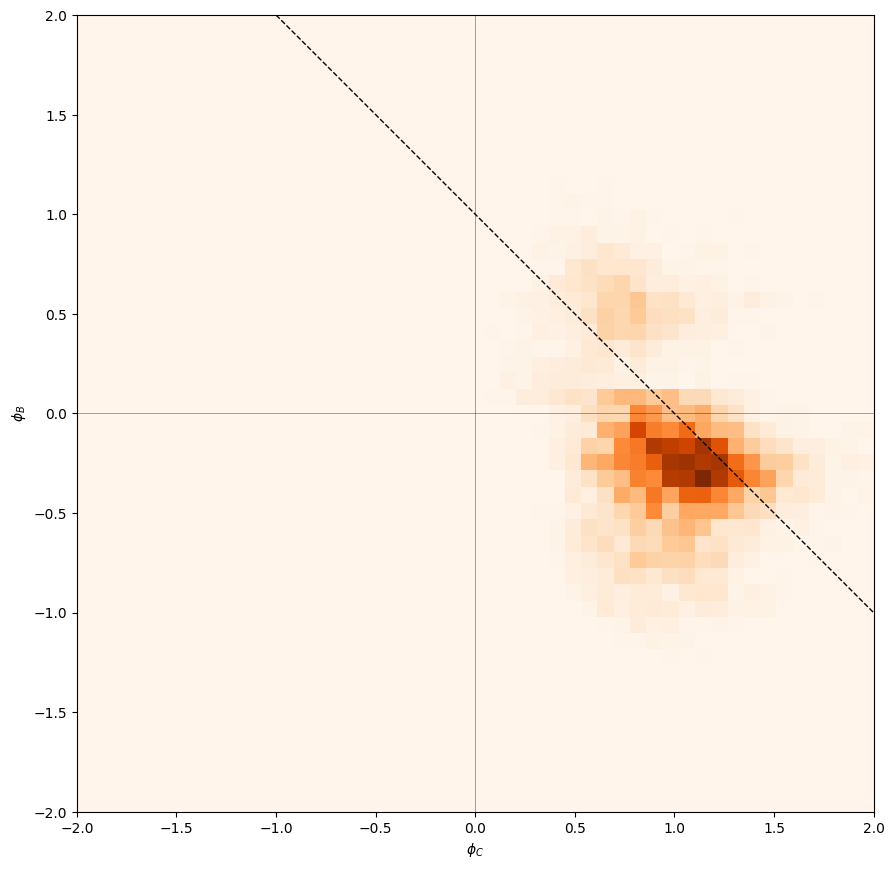

In [282]:
# Combine the histogram
flowrate_folder = r"C:\Users\liuzy\Documents\11042022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
data = []
for num, i in l.iterrows():    
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm
    data.append(norm_data)
combine = pd.concat(data, axis=0)
H, xedges, yedges = np.histogram2d(combine["crop-1_rb"], combine["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
ax = fig.add_subplot(1, 1, 1)
ax.imshow(H, interpolation='nearest', origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
ax.set_xlabel("$\phi_C$")
ax.set_ylabel("$\phi_B$")
plt.tight_layout()

#### 4.4.3 11072022 Data

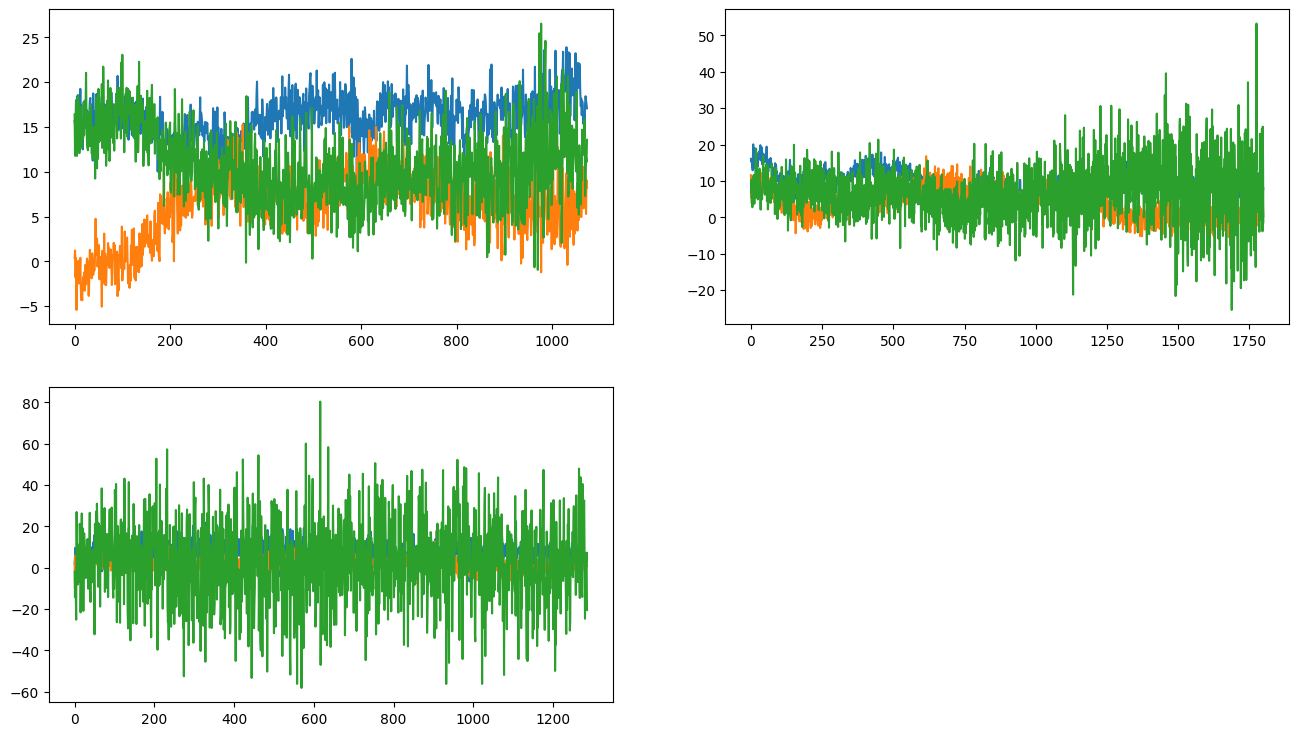

In [283]:
# flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\11072022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    ax.plot(fr["t"], fr["crop-0_rb"])
    ax.plot(fr["t"], fr["crop-1_rb"])
    ax.plot(fr["t"], fr["crop-2_rb"])

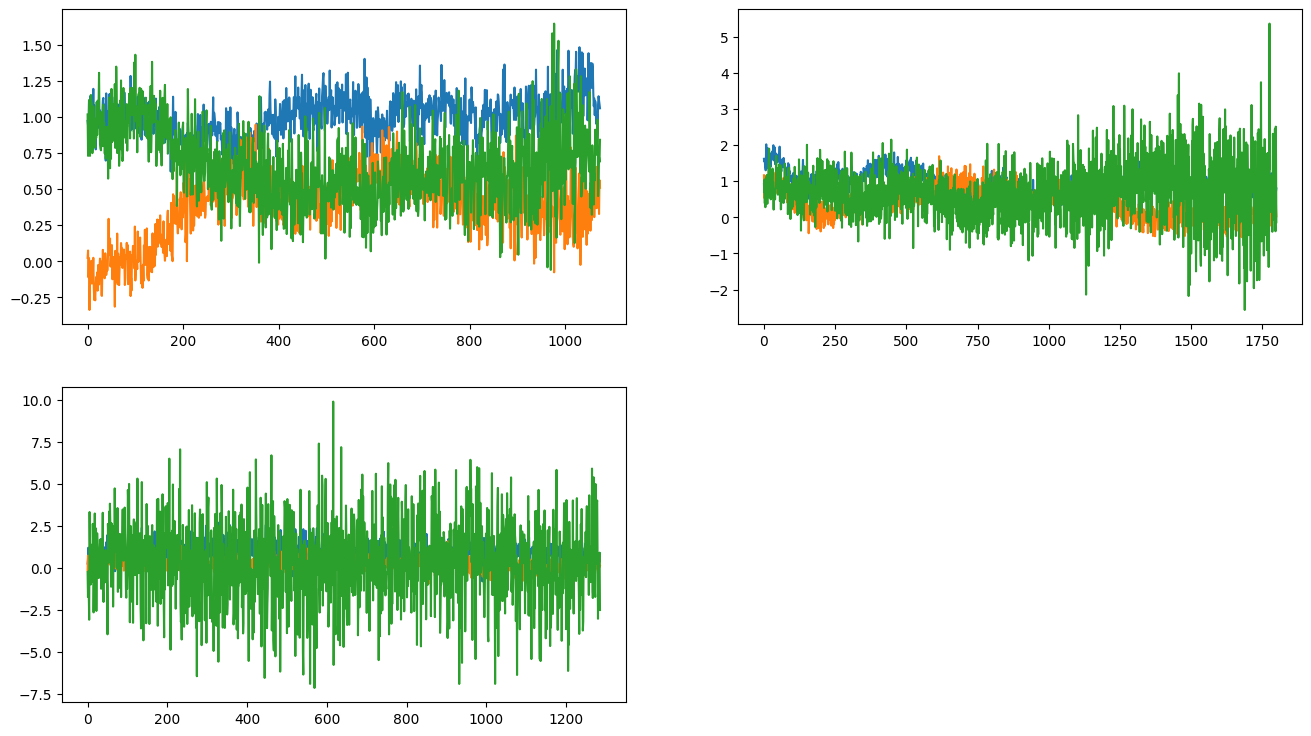

In [284]:
# normalized flow rate time series
flowrate_folder = r"C:\Users\liuzy\Documents\11072022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(16,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    ax.plot(fr["t"], fr["crop-0_rb"]/norm)
    ax.plot(fr["t"], fr["crop-1_rb"]/norm)
    ax.plot(fr["t"], fr["crop-2_rb"]/norm)

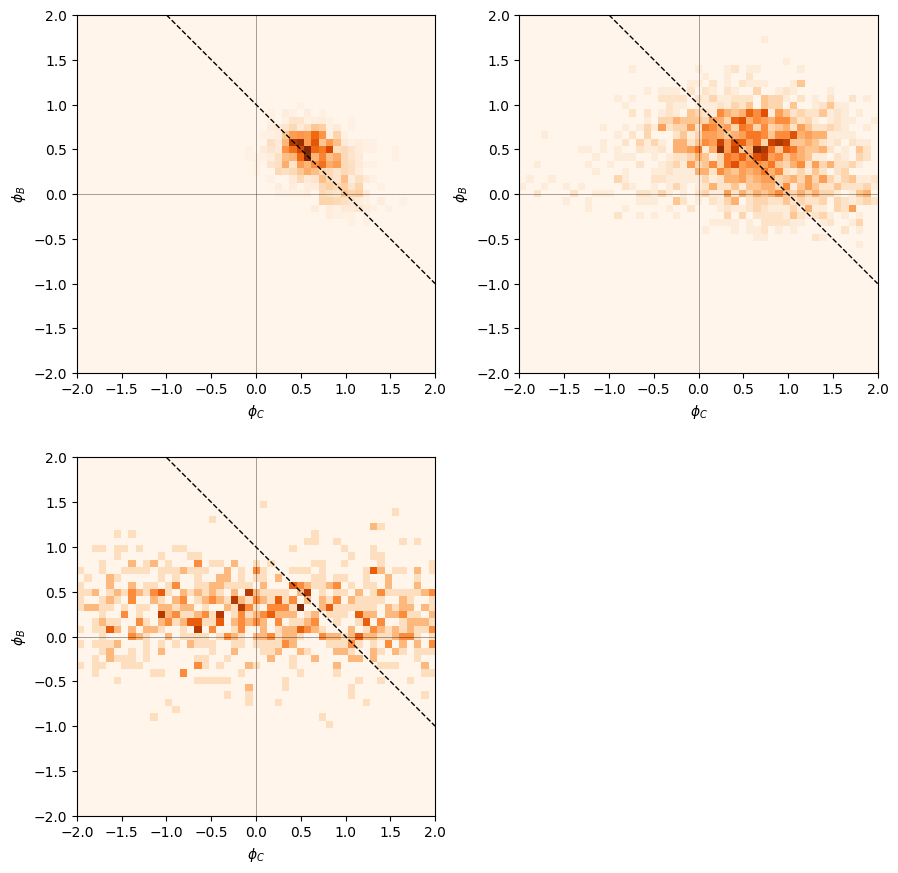

In [286]:
# Histogram of normalized flow rate (each)
flowrate_folder = r"C:\Users\liuzy\Documents\11072022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
for num, i in l.iterrows():
    ax = fig.add_subplot(2, 2, num+1)
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm
    H, xedges, yedges = np.histogram2d(norm_data["crop-1_rb"], norm_data["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
    ax.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
    ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
    ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
    ax.set_xlabel("$\phi_C$")
    ax.set_ylabel("$\phi_B$")
plt.tight_layout()

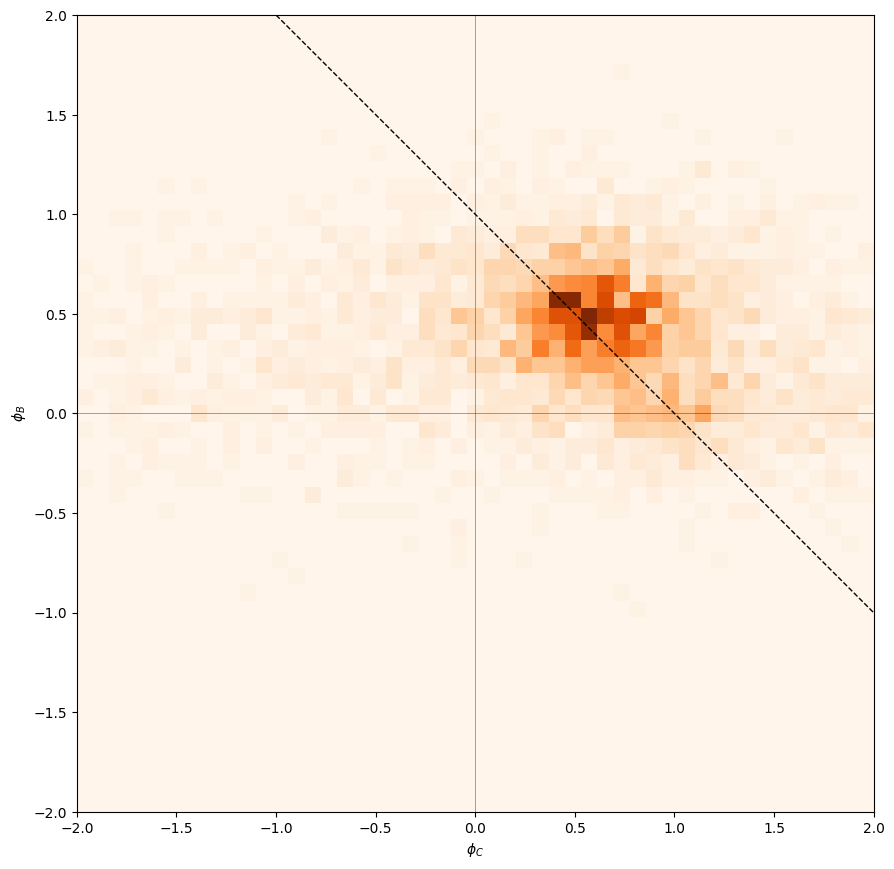

In [287]:
# Combine the histogram
flowrate_folder = r"C:\Users\liuzy\Documents\11072022\flowrate"
l = readdata(flowrate_folder, "csv")
numData = len(l)
fig = plt.figure(figsize=(9,9))
data = []
for num, i in l.iterrows():    
    fr = pd.read_csv(i.Dir)
    norm_data = fr.copy()
    norm = fr.drop(columns=["t"]).mean(axis=0).max()
    norm_data[["crop-0_rb", "crop-1_rb", "crop-2_rb"]] /= norm
    data.append(norm_data)
combine = pd.concat(data, axis=0)
H, xedges, yedges = np.histogram2d(combine["crop-1_rb"], combine["crop-2_rb"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
ax = fig.add_subplot(1, 1, 1)
ax.imshow(H, interpolation='nearest', origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-2, 2], [0, 0], color="black", lw=0.5, alpha=0.5)
ax.plot([0, 0], [-2, 2], color="black", lw=0.5, alpha=0.5)
ax.plot([-1, 2], [2, -1], color="black", ls="--", lw=1)
ax.set_xlabel("$\phi_C$")
ax.set_ylabel("$\phi_B$")
plt.tight_layout()

## 5 The automated workflow

- Crop images into separated channels: `crop_channel.py`
- PIV using ImageJ macro: `PIV_STACK_directory.ijm`
- Rename PIV data files generated by ImageJ to .csv: `rename_ij_piv.py`
- Apply mask to .csv PIV data: `apply_mask.py`
- Wrap PIV data in a more compact form: `wrap_piv.py`
- Flow rate analysis: `flowrate.py`

See the note `Notes/2022-12-13_bifurcation-analysis.pdf` for more details.

## 6 Data summary / visualization

We've got a nice organization of the bifurcation data. However, when going into the data folder, the only information we can get is still the DRY numbers representing flow rates in each channel evolving over time. An overview is needed for each day of experiment (or each grid, usually we do one grid a day). The overview should make clear the key information from the dataset. An example is illustrated below:

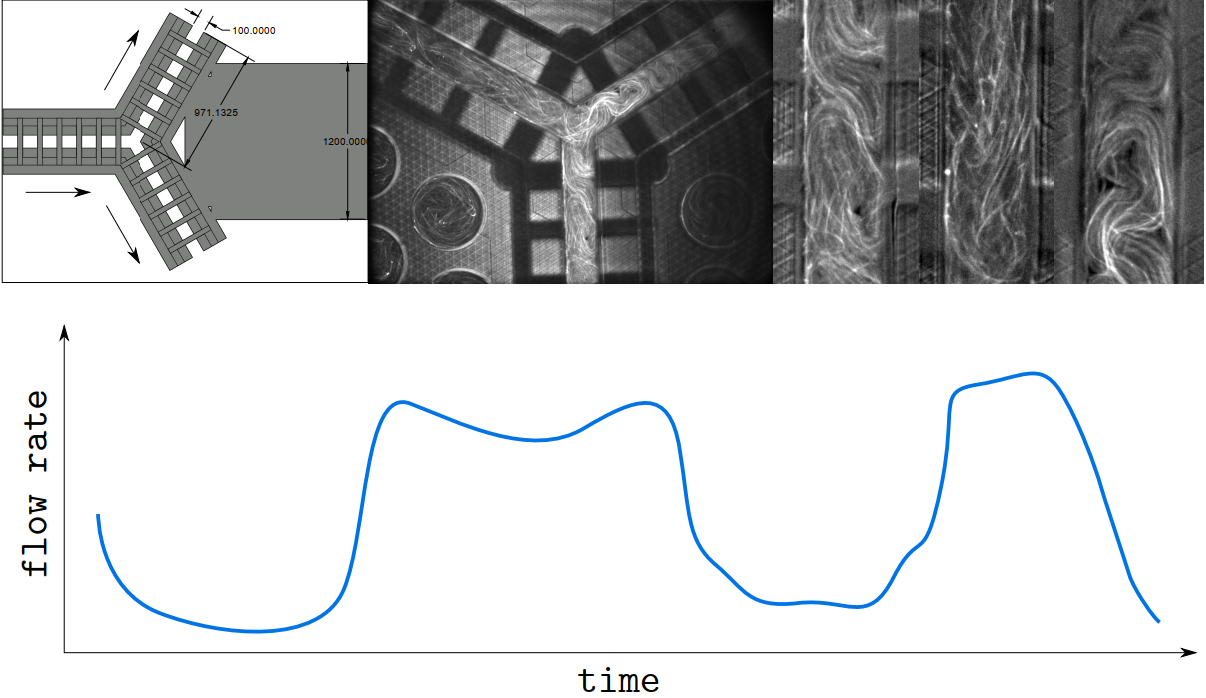

I think the best place to put the overview is the main data folder under which we have many date folders. There we can create PPT slides and make each page a summary of one day's experiment.

### 6.1 Combined flow rate plot

The flow rate data comes from the Flow_rate folder. Different files represent data measured from different videos. But usually, we have more than one videos for each grid, and it is ideal to combine flow rate data for the same grid in one plot. This section implement the combined flow rate plot.

(0.0, 7196.0)

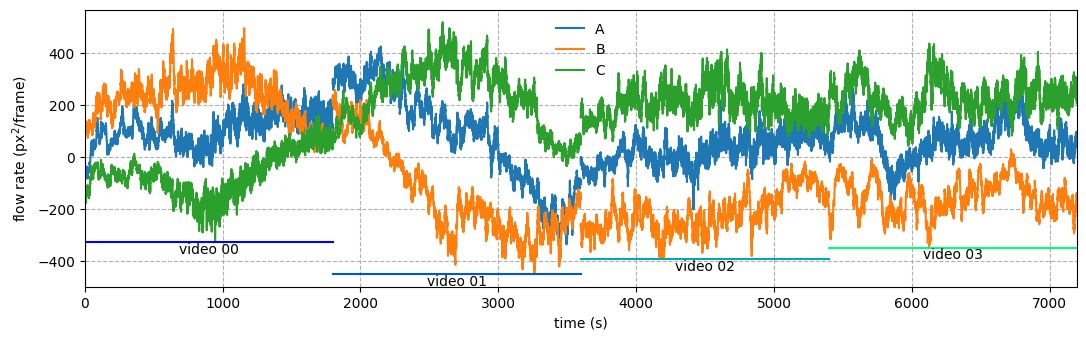

In [52]:
folder = r"A:\SYMMETRIC\15 dec 2022\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 4)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(12.8, 3.6), dpi=100)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    if num == 0:
        plt.plot(flowrate.t + offset, flowrate.A, color=colors(0), label="A")
        plt.plot(flowrate.t + offset, flowrate.B, color=colors(1), label="B")
        plt.plot(flowrate.t + offset, flowrate.C, color=colors(2), label="C")
    else:
        plt.plot(flowrate.t + offset, flowrate.A, color=colors(0))
        plt.plot(flowrate.t + offset, flowrate.B, color=colors(1))
        plt.plot(flowrate.t + offset, flowrate.C, color=colors(2))
    # video indicator
    offset0 = offset
    offset += flowrate["t"].max()
    y = flowrate[["A", "B", "C"]].min().min()
    plt.plot([offset0, offset], [y, y], color=video_colors(num))
    plt.annotate("video {:02d}".format(num), ((offset0+offset)/2, y), xycoords="data", 
                horizontalalignment="center", verticalalignment="top")
plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("flow rate (px$^2$/frame)")
plt.xlim([0, offset])

### 6.2 Flow rate histogram

This is the easiest visualization to see if the bifurcation is equally probable or polarized. Add this to the data over view. 

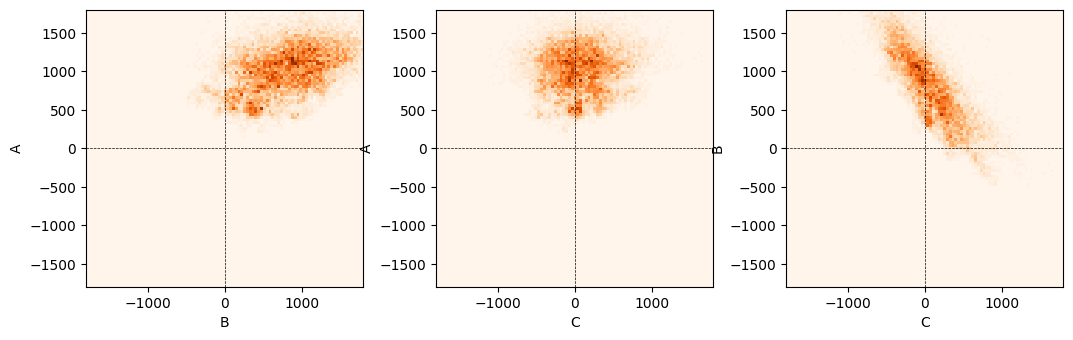

In [65]:
folder = r"A:\SYMMETRIC\17 oct 2022\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(4, 19)]
# colors = plt.cm.get_cmap("tab10")
# video_colors = plt.cm.get_cmap("winter", len(files))

fig, ax = plt.subplots(ncols=3, figsize=(12.8, 3.6), dpi=100)
fr_list = []
lim = 1800
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    fr_list.append(flowrate)
combined = pd.concat(fr_list)
for num, i1, i2 in ((0, "A", "B"), (1, "A", "C"), (2, "B", "C")):
    H, xedges, yedges = np.histogram2d(combined[i1], combined[i2], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
    ax[num].imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax[num].plot([-lim, lim], [0, 0], ls="--", lw=0.5, color="black")
    ax[num].plot([0, 0], [-lim, lim], ls="--", lw=0.5, color="black")
    ax[num].set_xlim([-lim, lim])
    ax[num].set_ylim([-lim, lim])
    ax[num].set_xlabel(i2)
    ax[num].set_ylabel(i1)
# plt.grid(True, ls="--")
# plt.legend(frameon=False)
# plt.xlabel("time (s)")
# plt.ylabel("flow rate (px$^2$/frame)")
# plt.xlim([0, offset])

# Appendix

## A. Investigate the weird spikes in ImageJ PIV results

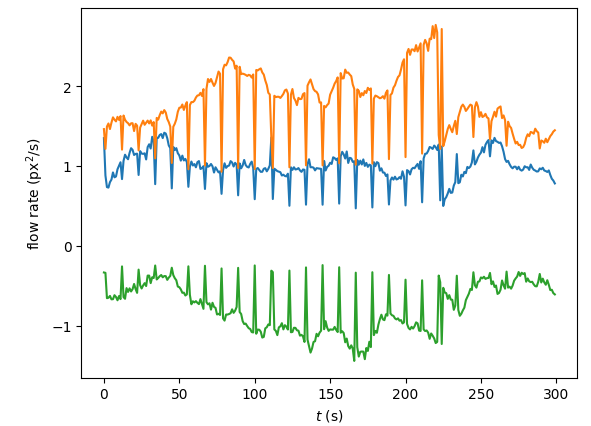

### Where are the spikes?

We can smooth the time series data first, then select the data points that show large deviation. They are the spikes. 

In [232]:
from scipy.signal import medfilt
from myImageLib import bestcolor

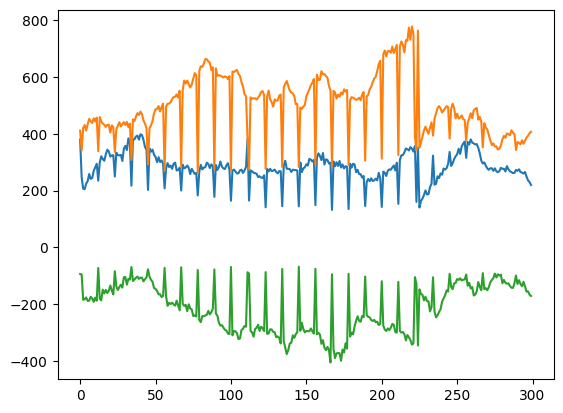

In [231]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
plt.plot(fr_ij["crop-0"])
plt.plot(fr_ij["crop-1"])
plt.plot(fr_ij["crop-2"])

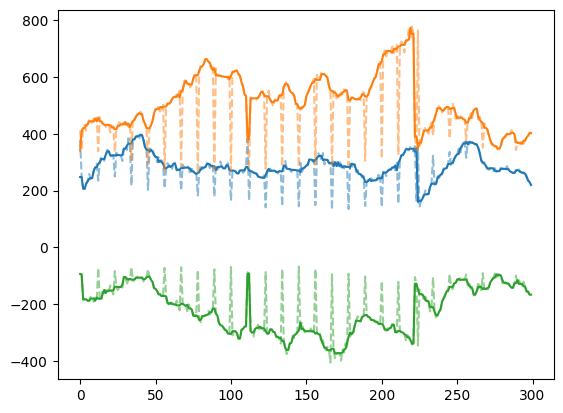

In [236]:
# plot filtered time series
plt.plot(fr_ij["crop-0"], color=bestcolor(0), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-0"],3), color=bestcolor(0))
plt.plot(fr_ij["crop-1"], color=bestcolor(1), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-1"],3), color=bestcolor(1))
plt.plot(fr_ij["crop-2"], color=bestcolor(2), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-2"],3), color=bestcolor(2))

Here, let's set the criterion as "deviation greater than the mean deviation".

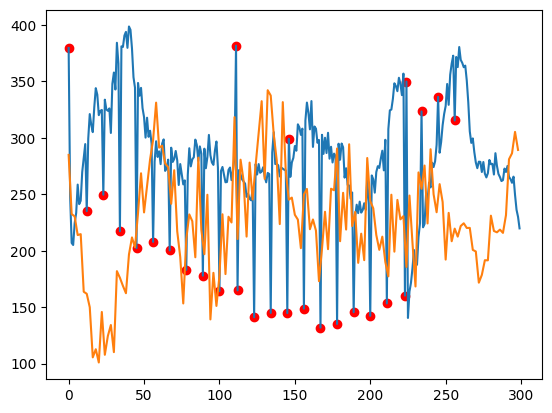

In [243]:
dev = abs(fr_ij["crop-0"] - medfilt(fr_ij["crop-0"],3))
spike_ind = dev > 2 * dev.mean()
plt.plot(fr_ij["crop-0"])
plt.plot(fr_py["t"], fr_py["crop-0"])
plt.scatter(fr_ij[spike_ind].t, fr_ij[spike_ind]["crop-0"], color="red")

### Why I did not see the spikes in the mean velocity time series?

Compute mean velocity again!

In [6]:
ijpiv_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"

# mask treatment
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
## py piv
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool_py = mask >= mask.max()
## ij piv
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))
pivData = pd.read_csv(os.path.join(ijpiv_folder, "_1.txt"), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
mask_bool_ij = mask_shrink.astype("bool")[pivData.y, pivData.x]

In [7]:
l = readdata(ijpiv_folder, "txt")
v_list = []
for num, i in l.iterrows():
    pivData = pd.read_csv(i.Dir, sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    
    v = -pivData_masked.v.mean()
    v_list.append(v)

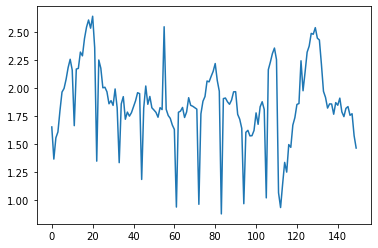

In [12]:
plt.plot(v_list[1::2])

In [17]:
l = readdata(ijpiv_folder, "txt")
c_list = []
for num, i in l.iterrows():
    c_list.append(i.Name)
print(c_list)

['_1', '_10', '_100', '_101', '_102', '_103', '_104', '_105', '_106', '_107', '_108', '_109', '_11', '_110', '_111', '_112', '_113', '_114', '_115', '_116', '_117', '_118', '_119', '_12', '_120', '_121', '_122', '_123', '_124', '_125', '_126', '_127', '_128', '_129', '_13', '_130', '_131', '_132', '_133', '_134', '_135', '_136', '_137', '_138', '_139', '_14', '_140', '_141', '_142', '_143', '_144', '_145', '_146', '_147', '_148', '_149', '_15', '_150', '_151', '_152', '_153', '_154', '_155', '_156', '_157', '_158', '_159', '_16', '_160', '_161', '_162', '_163', '_164', '_165', '_166', '_167', '_168', '_169', '_17', '_170', '_171', '_172', '_173', '_174', '_175', '_176', '_177', '_178', '_179', '_18', '_180', '_181', '_182', '_183', '_184', '_185', '_186', '_187', '_188', '_189', '_19', '_190', '_191', '_192', '_193', '_194', '_195', '_196', '_197', '_198', '_199', '_2', '_20', '_200', '_201', '_202', '_203', '_204', '_205', '_206', '_207', '_208', '_209', '_21', '_210', '_211', '_212',

I understand! The problem is from the data reading order. We want the order to be sorted by number, but in fact the software by default sort by character order. As a result, the default data read order is `['_1', '_10', '_100', '_101', '_102', '_103', '_104', '_105', '_106', '_107', '_108', '_109', '_11', '_110', '_111', '_112', '_113', '_114', '_115', '_116', '_117', '_118', '_119', '_12']`. 100-109 is consecutive, then 11 is an outlier, thus a spike. Then we have 110-119 consecutive, then 12 is an outlier. This explains why we see a spike every 11 points. 

In the previous section, we read the ij PIV data by iterating number $i$ in a range, avoiding sorting data file names. Therefore we don't see spikes there. In the following, we try to read PIV data in the right order. 

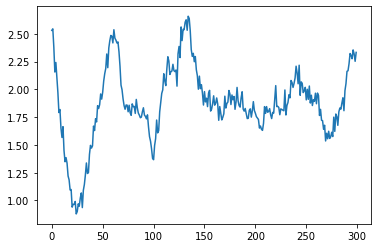

In [20]:
v_list = []
for i in range(1, 301):
    pivData = pd.read_csv(os.path.join(ijpiv_folder, "_{:d}.txt".format(i)), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    
    v = -pivData_masked.v.mean()
    v_list.append(v)
plt.plot(v_list)

In [252]:
next(os.walk(r"C:\Users\liuzy\Documents\01172022"))[1]

['mask',
 'mean_velocity',
 'preview',
 'velocity_autocorr',
 'velocity_autocorr.old']

### A simple script to test PIV

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

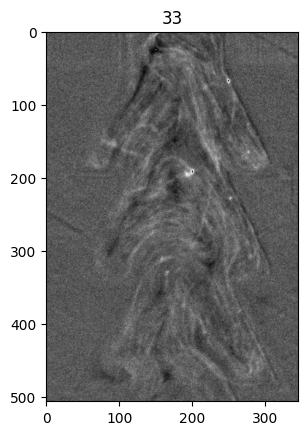

In [270]:
img_folder = r"C:\Users\liuzy\Documents\10312022\crop_channel\00\crop-0_rb"
piv_folder = r"C:\Users\liuzy\Documents\10312022\PIV\00\crop-0_rb"

l = readdata(piv_folder, "csv")
for num, i in l.iterrows():
    # img = io.imread(os.path.join(img_folder, "{}.tif".format(i.Name.split("-")[0])))
    x, y, u, v = read_piv(i.Dir)
    plt.title(num)
    plt.imshow(img, cmap="gray")
    plt.quiver(x, y, u, v, color="yellow")
    plt.pause(.1)
    plt.close()
    clear_output(wait=True)

## B. Compare Python and ImageJ PIV

We will take 10172022/04 as an example. Eventually, all the videos on 10172022 will be analyzed for comparison. We will be comparing:

- flow field in general: by computing error for each velocity and taking average (for each component)
$$
E_v = \frac{1}{n}\sum_{i=1}^{n} \frac{| v_{\text{python}} - v_{\text{ImageJ}} |}{| v_{\text{python}}  |}
$$
- flow rate: by computing error of low rate for each image 
$$
E_Q =  \frac{| Q_{\text{python}} - Q_{\text{ImageJ}} |}{| Q_{\text{python}}  |}
$$
Then take the mean of the errors from all the images, as a metric of the difference between the two PIV methods. 

### B.1 Create tiff stack

In [74]:
from tifffile import imwrite

In [77]:
image = np.random.rand(*(32, 256, 256))
imwrite("test.tif", image)

In [83]:
folder = r"E:\AN\10172022\channel_crops_rb"
for n in range(5, 19):
    subfolder = os.path.join(folder, "{:02d}".format(n))
    sfL = next(os.walk(subfolder))[1]    
    for sf in sfL:
        img_folder = os.path.join(subfolder, sf)
        print(img_folder)
        l = readdata(img_folder, "tif")
        img_list = []
        for num, i in l.iterrows():
            print(num, end="\r")
            img = io.imread(i.Dir)
            img_list.append(img)
        stack = np.stack(img_list, axis=0)
        imwrite(os.path.join(subfolder, "{}.tif".format(sf)), stack)

E:\AN\10172022\channel_crops_rb\05\crop-0
E:\AN\10172022\channel_crops_rb\05\crop-1
E:\AN\10172022\channel_crops_rb\05\crop-2
E:\AN\10172022\channel_crops_rb\06\crop-0
E:\AN\10172022\channel_crops_rb\06\crop-1
E:\AN\10172022\channel_crops_rb\06\crop-2
E:\AN\10172022\channel_crops_rb\07\crop-0
E:\AN\10172022\channel_crops_rb\07\crop-1
E:\AN\10172022\channel_crops_rb\07\crop-2
E:\AN\10172022\channel_crops_rb\08\crop-0
E:\AN\10172022\channel_crops_rb\08\crop-1
E:\AN\10172022\channel_crops_rb\08\crop-2
E:\AN\10172022\channel_crops_rb\09\crop-0
E:\AN\10172022\channel_crops_rb\09\crop-1
E:\AN\10172022\channel_crops_rb\09\crop-2
E:\AN\10172022\channel_crops_rb\10\crop-0
E:\AN\10172022\channel_crops_rb\10\crop-1
E:\AN\10172022\channel_crops_rb\10\crop-2
E:\AN\10172022\channel_crops_rb\11\crop-0
E:\AN\10172022\channel_crops_rb\11\crop-1
E:\AN\10172022\channel_crops_rb\11\crop-2
E:\AN\10172022\channel_crops_rb\12\crop-0
E:\AN\10172022\channel_crops_rb\12\crop-1
E:\AN\10172022\channel_crops_rb\12

### B.2 Read PIV data from ImageJ 

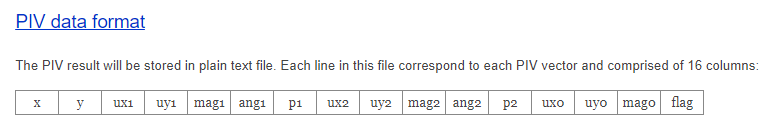

In [3]:
data_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
l = readdata(data_folder, "txt")
pivData = pd.read_csv(l.loc[0].Dir, sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])

In [4]:
img_folder = r"E:\AN\10172022\channel_crops_rb\04\crop-0"
li = readdata(img_folder, "tif")
img = io.imread(li.loc[0].Dir)

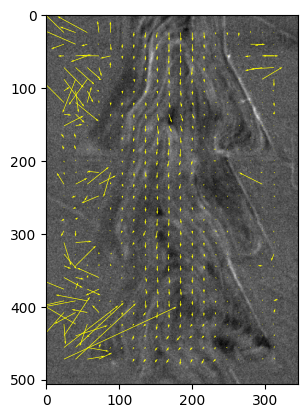

In [5]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v, color="yellow")

Apparently, the ImageJ PIV gives opposite velocity in $y$, compared to Python PIV. Need to be careful with this difference.

### B.3 Apply mask

In [65]:
def apply_mask(pivData, mask, erode=1):
    mask = cv2.erode(mask.astype("uint8"), np.ones((erode, erode), dtype="uint8"))
    mask = mask > mask.mean()
    ind = mask[pivData.y.astype("int"), pivData.x.astype("int")]
    p = pivData.copy() # avoid setting values to the original copy
    p.loc[~ind, ["u", "v"]] = np.nan
    return p

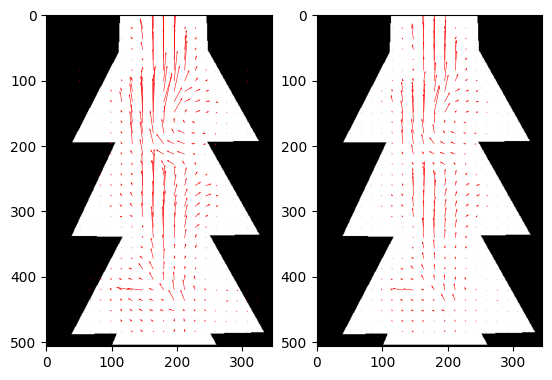

In [69]:
# test
pivData = pd.read_csv("test_files/piv-test.csv")
mask = io.imread("test_files/mask.tif")
mpiv = apply_mask(pivData, mask)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(mask, cmap="gray")
ax[0].quiver(pivData.x, pivData.y, pivData.u, pivData.v, color="red")
ax[1].imshow(mask, cmap="gray")
ax[1].quiver(mpiv.x, mpiv.y, mpiv.u, mpiv.v, color="red")

In [2]:
piv_folder = r"E:\AN\10172022\channel_piv_rb"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
sfL = ["crop-0", "crop-1", "crop-2"]
for n in range(4, 5):
    for sf in sfL:
        mask = io.imread(os.path.join(mask_folder, "{}.tif".format(sf)))        
        l = readdata(os.path.join(piv_folder, "{:02d}".format(n), sf), "csv")
        save_folder = os.path.join(piv_folder, "{:02d}".format(n), "{}_masked".format(sf))
        if os.path.exists(save_folder) == False:
            os.makedirs(save_folder)
        for num, i in l.iterrows():
            pivData = pd.read_csv(i.Dir)
            mpiv = apply_mask(pivData, mask)
            mpiv.to_csv(os.path.join(save_folder, "{}.csv".format(i.Name)), index=False)

C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\matplotlib\quiver.py:633: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


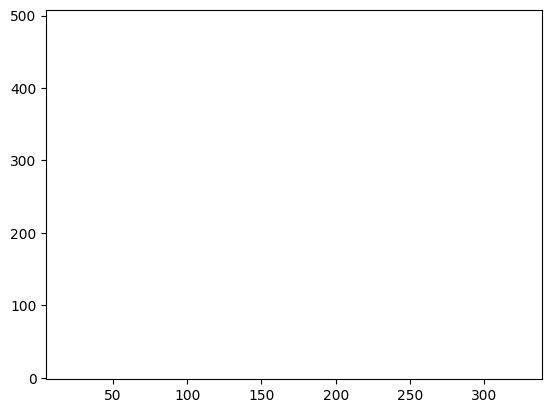

In [6]:
folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
n = 0
x, y, u, v = read_piv(os.path.join(folder, "{0:05d}-{1:05d}.csv".format(n, n+1)))
plt.quiver(x, y, u, v)

In [94]:
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool = mask >= mask.max()

My old way of applying masks requires that the PIV windows are put in the same way as my function `divide_windows`. This is not true for the ImageJ PIV. So here we seek a new way to mask PIV results. An intuitive method is to check the PIV xy's one by one, see if they are True or false in the image size mask.

In [135]:
mask_bool = mask_raw.astype("bool")[pivData.y, pivData.x]

In [114]:
pivData_masked = pivData.copy()
pivData_masked.loc[~mask_bool, "u"] = np.nan
pivData_masked.loc[~mask_bool, "v"] = np.nan

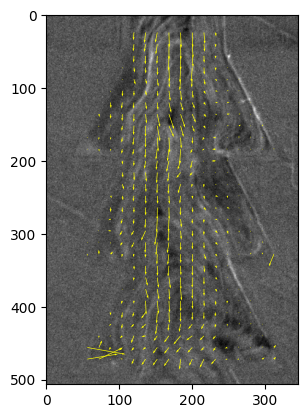

In [116]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, pivData_masked.v, color="yellow")

#### Mask near boundary regions -> shrink the mask further

In [142]:
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))

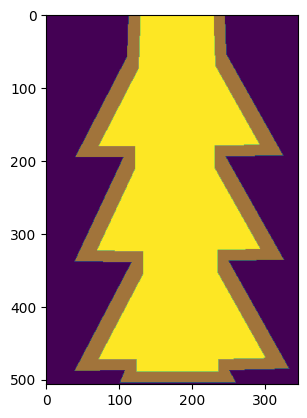

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(mask_raw)
ax.imshow(mask_shrink, alpha=0.5)

In [144]:
mask_bool = mask_shrink.astype("bool")[pivData.y, pivData.x]

In [145]:
pivData_masked = pivData.copy()
pivData_masked.loc[~mask_bool, "u"] = np.nan
pivData_masked.loc[~mask_bool, "v"] = np.nan

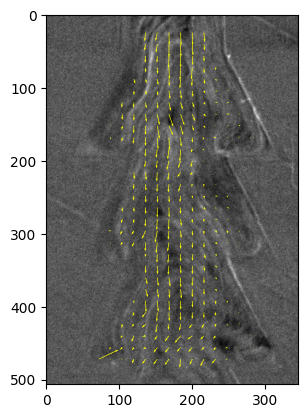

In [146]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, pivData_masked.v, color="yellow")

### B.4 Compare with Python results

In [147]:
pypiv_folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
x, y, u, v = read_piv(os.path.join(pypiv_folder, "00000-00001.csv"))
# load mask
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool = mask >= mask.max()
# apply mask
u[~mask_bool] = np.nan
v[~mask_bool] = np.nan

(-0.5, 344.5, 506.5, -0.5)

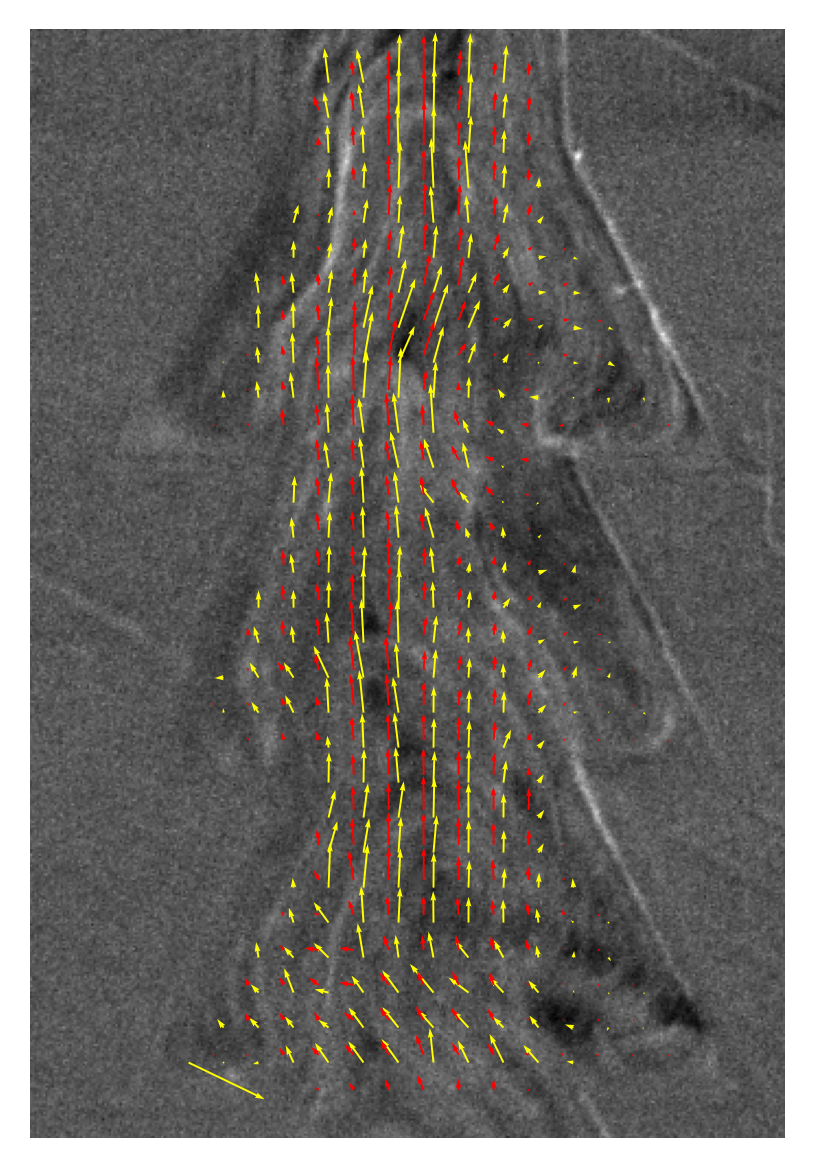

In [149]:
plt.figure(dpi=300)
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, -pivData_masked.v, color="yellow", scale=90)
plt.quiver(x, y, u, v, color="red", scale=90)
plt.axis("off")

#### Mean velocity (vertical)

In [153]:
vi = -pivData_masked.v.mean()
vp = np.nanmean(v)
e = abs(vp - vi) / vp
print(vi, vp, "error={:.2f}".format(e))

2.531077389817271 1.6504453681778235 error=0.53


This is a decent error between the mean velocities. Although the flow field look quite similar.

#### Compare a whole video

In [9]:
img_folder = r"E:\AN\10172022\channel_crops_rb\04\crop-0"
ijpiv_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
pypiv_folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"

# mask treatment
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
## py piv
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool_py = mask >= mask.max()
## ij piv
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))
pivData = pd.read_csv(os.path.join(ijpiv_folder, "_1.txt"), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
mask_bool_ij = mask_shrink.astype("bool")[pivData.y, pivData.x]

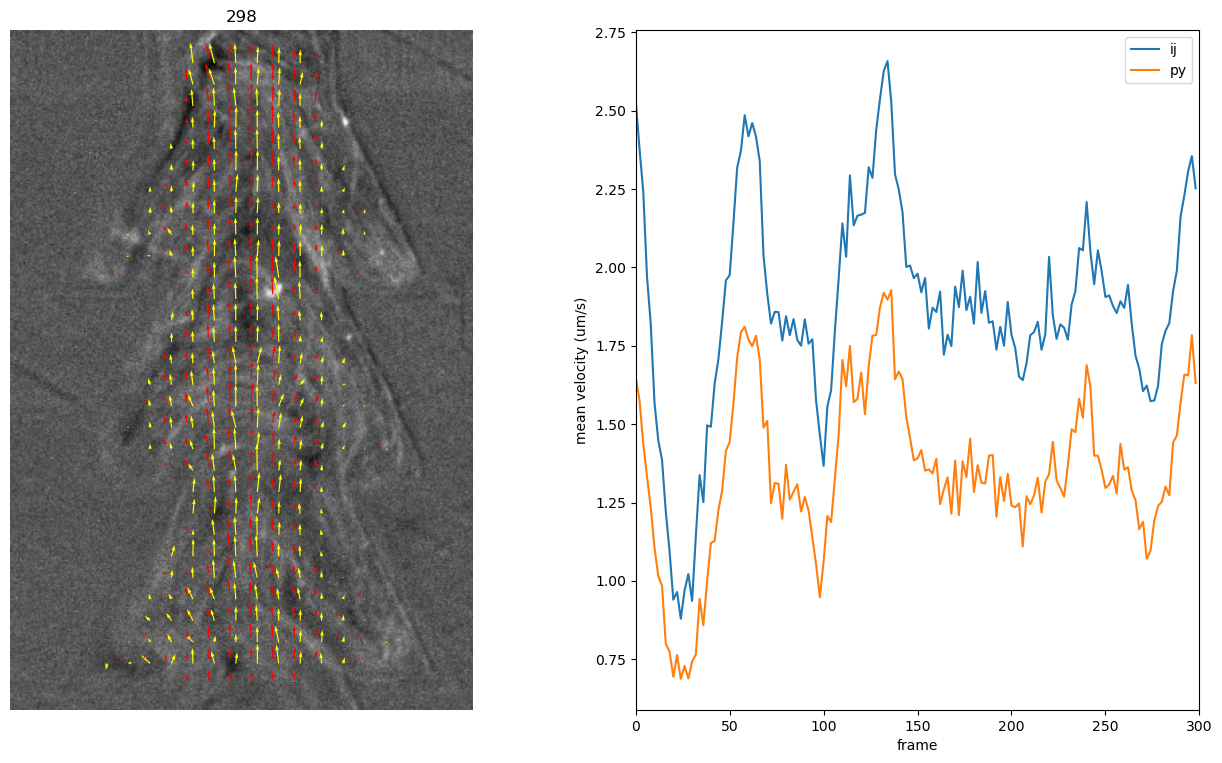

In [10]:
l = readdata(pypiv_folder, "csv")
e_list, vi_list, vp_list = [], [], []
for num, i in l.iterrows():
    # load image
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(2*num)))
    # load data
    x, y, u, v = read_piv(i.Dir)
    pivData = pd.read_csv(os.path.join(ijpiv_folder, "_{:d}.txt".format(num*2+1)), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    u[~mask_bool_py] = np.nan
    v[~mask_bool_py] = np.nan
    # compute & record error
    vi = -pivData_masked.v.mean()
    vp = np.nanmean(v)
    e = abs(vp - vi) / vp
    vi_list.append(vi)
    vp_list.append(vp)
    e_list.append(e)
    # draw
    fig, ax = plt.subplots(ncols=2, figsize=(16, 9), dpi=100)
    ax[0].set_title(2*num)
    ax[0].imshow(img, cmap="gray")
    ax[0].quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, -pivData_masked.v, color="yellow", scale=90)
    ax[0].quiver(x, y, u, v, color="red", scale=90)
    ax[0].axis("off")
    # plot mean velocity (flow rate)
    ax[1].plot(range(0, 2*num+1, 2), vi_list, label="ij")
    ax[1].plot(range(0, 2*num+1, 2), vp_list, label="py")
    ax[1].set_ylabel("mean velocity (um/s)")
    ax[1].set_xlabel("frame")
    ax[1].set_xlim([0, 300])
    # ax[1].set_ylim([1, 4])
    ax[1].legend(loc="upper right")
    # savefig
    # fig.savefig("{:05d}.jpg".format(2*num))
    plt.pause(.001)
    plt.close()
    clear_output(wait=True)

#### Compare $\phi_B$-$\phi_C$ histogram

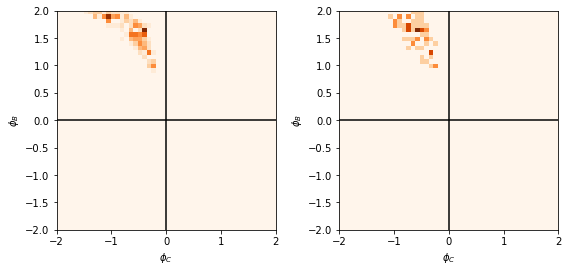

In [25]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
fr_py = pd.read_csv("test_files/flowrate/py.csv")
fr_ij[["crop-1", "crop-2"]] /= fr_ij["crop-0"].mean()
fr_py[["crop-1", "crop-2"]] /= fr_py["crop-0"].mean()

H1, xedges, yedges = np.histogram2d(fr_ij["crop-1"], fr_ij["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
H2, xedges, yedges = np.histogram2d(fr_py["crop-1"], fr_py["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(H1, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax[0].plot([-2, 2], [0, 0], color="black")
ax[0].plot([0, 0], [-2, 2], color="black")
ax[0].set_xlabel("$\phi_C$")
ax[0].set_ylabel("$\phi_B$")

ax[1].imshow(H2, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax[1].plot([-2, 2], [0, 0], color="black")
ax[1].plot([0, 0], [-2, 2], color="black")
ax[1].set_xlabel("$\phi_C$")
ax[1].set_ylabel("$\phi_B$")


plt.tight_layout()
# plt.colorbar()

#### Flow rate and normalized flow rate

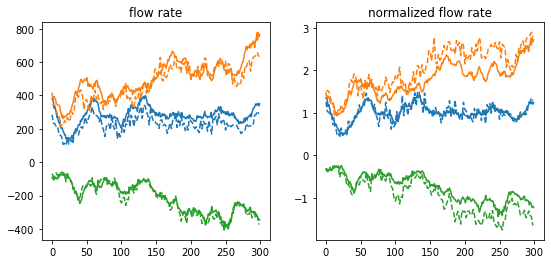

In [29]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
fr_py = pd.read_csv("test_files/flowrate/py.csv")
fr_ij_norm = fr_ij.copy()
fr_py_norm = fr_py.copy()
fr_ij_norm[["crop-0", "crop-1", "crop-2"]] /= fr_ij["crop-0"].mean()
fr_py_norm[["crop-0", "crop-1", "crop-2"]] /= fr_py["crop-0"].mean()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].set_title("flow rate")
ax[0].plot(fr_ij.t, fr_ij["crop-0"], color=bestcolor(0))
ax[0].plot(fr_py.t, fr_py["crop-0"], color=bestcolor(0), ls="--")
ax[0].plot(fr_ij.t, fr_ij["crop-1"], color=bestcolor(1))
ax[0].plot(fr_py.t, fr_py["crop-1"], color=bestcolor(1), ls="--")
ax[0].plot(fr_ij.t, fr_ij["crop-2"], color=bestcolor(2))
ax[0].plot(fr_py.t, fr_py["crop-2"], color=bestcolor(2), ls="--")

ax[1].set_title("normalized flow rate")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-0"], color=bestcolor(0))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-0"], color=bestcolor(0), ls="--")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-1"], color=bestcolor(1))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-1"], color=bestcolor(1), ls="--")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-2"], color=bestcolor(2))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-2"], color=bestcolor(2), ls="--")

### B.5 Call ImageJ PIV function in Python (fail)

Although I personally favor the OpenPIV Python module, which is developed and maintained actively, I understand Claire that she wants the data more consistent. So here I use the ImageJ PIV method to compute velocity field. This will require a package [Py4J](https://www.py4j.org/index.html).

** Failed **

The tutorial example worked, but applying it to the PIV class turns out to be not so straightforward. I briefly document what I have tried, for future reference.

1. I copy-paste the example code "Stack" from py4j tutorial and try to compile using `java Stack.java`, only to realize that I need to install JDK, on top of JRE to compile. JDK is for developer, apparently.

2. Installed JDK, I compile again and run into issues of undefined symbol "Stack". Although I define it already in a file and compile another file which is under the same package. Then I realize that the compile should be on both files in one command, like `java Entry.java Stack.java`, or more simply, `java *.java`.

3. After successfully compiling the code, I run it using `java Entry` (the class name), and it worked correctly. 

4. Using this knowledge on iterative_PIV.java, the compiling part worked as well. But when I try to run the `Entry` class, Java raises undefinedclass error of `ij.plugin.filter.pluginfilter`. I searched about this issue but did not learn much. 

Conclusion: the Java in Python approach is not working. Use ImageJ macro to do the automation.

In [25]:
from py4j.java_gateway import *
port = launch_gateway()
gateway = JavaGateway(
gateway_parameters=GatewayParameters(port=port),
callback_server_parameters=CallbackServerParameters(port=0))
random = gateway.jvm.java.util.Random()

In [28]:
stack.push("First %s" % ('item'))

In [29]:
stack.pop()

'First item'

## C. Try to read broken nd2 files

I notice that some nd2 files are not saved properly, so that the nd2reader package is not able to parse the data, resulting in the failure of my image processing script. Howeve, for some broken nd2 files, the problem appears to be very trivial, as ImageJ bioformats plugin has no problem opening the file and accessing all the frames. Therefore, I suspect that there is a workaround that allow me to open some "broken" nd2 files in Python (with bioformats packages). Here, I test this possibility. Refer to an [issue](https://github.com/Open-Science-Tools/nd2reader/issues/23) of nd2reader.

In [3]:
from pims import ND2_Reader
nd2Dir = r"A:\SYMMETRIC\15 dec 2022\nd2\02.nd2"
frames = ND2_Reader(nd2Dir)
frames[82]

AttributeError: partially initialized module 'pims' has no attribute 'pyav_reader' (most likely due to a circular import)

Apparently, the pims package has more issues and cannot be used even to uncorrupted nd2 files. Therefore, I convert the corrupted nd2 file to tiffstack first, and implement a crop_channel for tiffstack here to deal with corrupted nd2 files. 

### C.1 `crop_channel` for tiffstack

<font color="red"> This takes long time and consumes big memory, use with caution! </font>

In [33]:
stackDir = r"A:\SYMMETRIC\15 dec 2022\nd2\00.tif"
crop_data = pd.read_csv(r"A:\SYMMETRIC\15 dec 2022\nd2\crop_data.csv")

crop_folder = os.path.join(os.path.split(stackDir)[0], "crop_channel")
if os.path.exists(crop_folder) == False:
    os.makedirs(crop_folder)

# create a dist that holds the cropped images in all regions
crops = {}
for j in range(0, len(crop_data)//2):
     crops[j] = []

# crop nd2
images = io.imread(stackDir)
nImages = len(images)
for num, image in enumerate(images):
    show_progress((num+1)/nImages, str(num))
    for j in range(0, len(crop_data)//2): # loop over all possible croppings
        # convert to angle, xy, wh
        angle = 90 - crop_data.at[2*j, "Angle"]
        x, y, w, h = crop_data.at[2*j+1, "BX"], crop_data.at[2*j+1, "BY"], crop_data.at[2*j+1, "Width"], crop_data.at[2*j+1, "Height"]
        imgr = rotate(image, angle=angle) # rotate
        crop = imgr[y:y+h, x:x+w] # crop
        crops[j].append(crop)

In [36]:
# remove background and save
for j in crops:
    crops[j] = np.stack(crops[j])
    imwrite(os.path.join(crop_folder,  "{0}_{1}.tif".format(os.path.split(stackDir)[1].split(".")[0], chr(65+j))), to8bit(crops[j] / np.median(crops[j], axis=0)))

## D. Quick check PIV

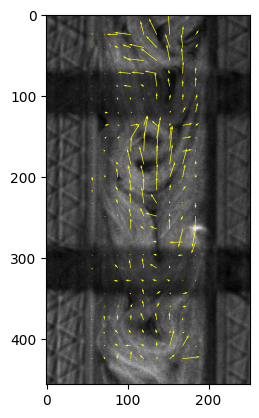

In [17]:
cpiv_dict = loadmat(r"A:\SYMMETRIC\15 dec 2022\PIV\00_A.mat")
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(0)
img = io.imread(r"A:\SYMMETRIC\15 dec 2022\tif\00_A.tif")
plt.imshow(img[0], cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

In [5]:
def compute_flowrate(x, y, u, v):
    """
    Compute volumetric flow rate from masked PIV results.
    x, y, u, v -- PIV data.
    """
    mask = ~np.isnan(v)
    x.astype("float")[~mask] = np.nan
    W = np.nanmax(x, axis=1) - np.nanmin(x, axis=1) # channel width along y, px
    v_meanx = np.nanmean(v, axis=1)
    Q = np.nanmean(W*v_meanx)
    return Q

Text(0, 0.5, '$\\overline{V_y}$')

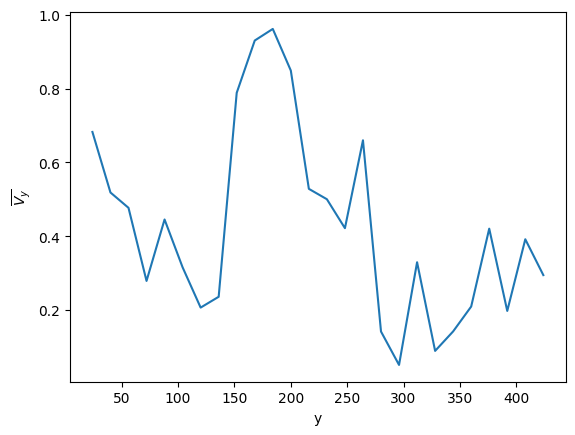

In [78]:
plt.plot(y[:, 0], np.nanmean(abs(v), axis=1))
plt.xlabel("y")
plt.ylabel("$\overline{V_y}$")

In [21]:
cpiv_dict = loadmat(r"A:\SYMMETRIC\15 dec 2022\PIV\00_A.mat")
cpiv = compact_PIV(cpiv_dict)
Q_list = []
Q_crop_list = []
for label in cpiv.get_labels():
    x, y, u, v = cpiv.get_frame(label, by="label")
    Q = compute_flowrate(x, y, u, v)
    Q_list.append(Q)    
    v[(y<120)|(y>280)] = np.nan
    Q = compute_flowrate(x, y, u, v)
    Q_crop_list.append(Q)    

C:\Users\liuzy\AppData\Local\Temp\ipykernel_26172\1819215642.py:9: RuntimeWarning: Mean of empty slice
  v_meanx = np.nanmean(v, axis=1)


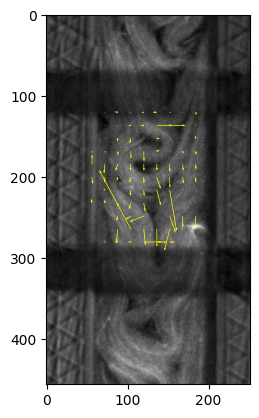

In [22]:
plt.imshow(img[1], cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

Text(0, 0.5, 'flow rate (px$^2$/s)')

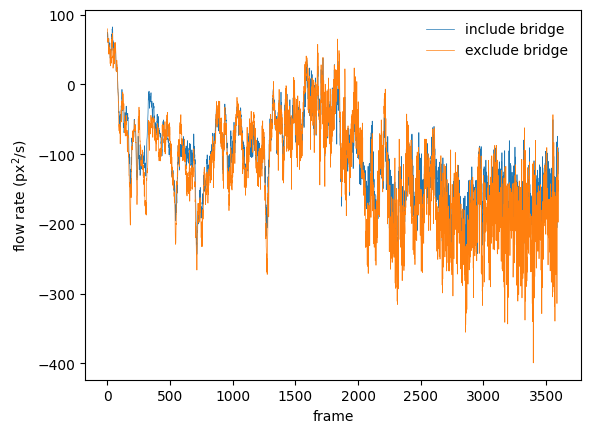

In [26]:
plt.plot(Q_list, lw=0.5, label="include bridge")
plt.plot(Q_crop_list, lw=0.5, label="exclude bridge")
plt.legend(frameon=False)
plt.xlabel("frame")
plt.ylabel("flow rate (px$^2$/s)")

In [29]:
-53.569-90

-143.56900000000002